In [1]:
# Import essenziali
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import Counter
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from tqdm.auto import tqdm
import shutil
import glob

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
!pip3 install opencv-python matplotlib pandas numpy pillow scikit-learn seaborn tqdm

# ANALISI ESPLORATIVA DEL DATASET

In [ ]:
def explore_dataset_structure(dataset_path):
    """Esplora la struttura del dataset e conta i file."""
    print("Struttura del dataset:")
    total_images = 0
    
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}📁 {os.path.basename(root)}/')
        
        # Conta file per tipo
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        txt_files = [f for f in files if f.lower().endswith('.txt')]
        weight_files = [f for f in files if f.lower().endswith('.weights')]
        
        sub_indent = ' ' * 2 * (level + 1)
        if image_files:
            print(f'{sub_indent}📸 Immagini: {len(image_files)}')
            total_images += len(image_files)
        if txt_files:
            print(f'{sub_indent}📝 File testo: {len(txt_files)}')
        if weight_files:
            print(f'{sub_indent}🏋️ Pesi YOLO: {len(weight_files)}')
    
    print(f'\n📊 Totale immagini trovate: {total_images}')
    return total_images

# Uso
total_imgs = explore_dataset_structure('/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/E-FPDS')

In [12]:
def analizza_dataset(base_path="E-FPDS", formato="custom", classi_yolo=None):
    """Analizza statistiche base del dataset con gestione errori
    
    Args:
        base_path (str): Percorso base del dataset
        formato (str): 'custom' per il formato originale o 'yolo' per il formato YOLO
        classi_yolo (dict, optional): Dizionario che mappa gli indici delle classi YOLO 
                                     ai nomi, es. {0: 'caduta', 1: 'non_caduta'}
                                     
    Returns:
        tuple: (dati, bboxes, distribuzione_bbox) con statistiche del dataset
    """
    print(f"Analisi dataset: {base_path} (formato: {formato})")
    
    # Valori predefiniti per classi YOLO se non specificate
    if formato == "yolo" and classi_yolo is None:
        classi_yolo = {0: 'caduta', 1: 'non_caduta'}
        print(f"Usando mappature classi YOLO predefinite: {classi_yolo}")
    
    # Mappatura split per formato custom
    mappatura = {
        'train': ['split1', 'split2', 'split3', 'split10', 'split11'],
        'test': ['split4', 'split5', 'split6', 'split7', 'split8'],
        'valid': ['split12', 'split13']
    }
    
    # Contatori
    dati = {
        'train': {'immagini': 0, 'cadute': 0, 'non_cadute': 0, 'immagini_con_cadute': 0, 'immagini_con_non_cadute': 0},
        'test': {'immagini': 0, 'cadute': 0, 'non_cadute': 0, 'immagini_con_cadute': 0, 'immagini_con_non_cadute': 0},
        'valid': {'immagini': 0, 'cadute': 0, 'non_cadute': 0, 'immagini_con_cadute': 0, 'immagini_con_non_cadute': 0},
        'val': {'immagini': 0, 'cadute': 0, 'non_cadute': 0, 'immagini_con_cadute': 0, 'immagini_con_non_cadute': 0}  # Aggiungi 'val' per supportare entrambe le convenzioni
    }
    
    # Statistiche bounding box
    bboxes = {'larghezza': [], 'altezza': [], 'area': []}
    
    # Inizializza distribuzione_bbox per entrambi i formati
    distribuzione_bbox = {
        'total': [],  # Numero totale di bounding box per immagine
        'fallen': [],  # Numero di bounding box 'caduta' per immagine
        'not_fallen': [],  # Numero di bounding box 'non-caduta' per immagine
        'set_info': {}  # Dizionario per tracciare il set di appartenenza di ogni immagine
    }
    
    # Verifica esistenza del percorso base
    if not os.path.exists(base_path):
        print(f"ERRORE: Il percorso base {base_path} non esiste!")
        return dati, bboxes, distribuzione_bbox
    
    # CASO 1: Formato personalizzato originale
    if formato == "custom":
        # Analizza ogni set
        for set_nome, splits in mappatura.items():
            for split in splits:
                percorso = os.path.join(base_path, set_nome, split)
                
                if not os.path.exists(percorso):
                    print(f"Split non trovato: {percorso}")
                    continue
                
                # Trova file txt
                try:
                    files_txt = [f for f in os.listdir(percorso) if f.endswith('.txt')]
                except Exception as e:
                    print(f"Errore lettura directory {percorso}: {e}")
                    continue
                
                for file_txt in files_txt:
                    file_img = file_txt.replace('.txt', '.png')
                    percorso_img = os.path.join(percorso, file_img)
                    
                    if os.path.exists(percorso_img):
                        dati[set_nome]['immagini'] += 1
                        
                        # Leggi annotazioni
                        try:
                            percorso_txt = os.path.join(percorso, file_txt)
                            
                            # Contatori per questa immagine specifica
                            cadute_in_immagine = False
                            non_cadute_in_immagine = False
                            cadute_count = 0
                            non_cadute_count = 0
                            
                            with open(percorso_txt, 'r') as f:
                                linee = f.readlines()
                                
                                for linea in linee:
                                    parti = linea.strip().split()
                                    if len(parti) >= 5:
                                        try:
                                            classe = int(parti[0])
                                            left = int(parti[1])
                                            right = int(parti[2])
                                            top = int(parti[3])
                                            bottom = int(parti[4])
                                            
                                            # Calcoli dimensioni
                                            try:
                                                larghezza = right - left
                                                altezza = bottom - top
                                                area = int(larghezza * altezza)
                                                
                                                if larghezza > 0 and altezza > 0:
                                                    bboxes['larghezza'].append(larghezza)
                                                    bboxes['altezza'].append(altezza)
                                                    bboxes['area'].append(area)
                                            except Exception as e:
                                                pass  # Ignora errori di calcolo
                                            
                                            # Conteggi per classe
                                            if classe == 1:
                                                dati[set_nome]['cadute'] += 1
                                                cadute_in_immagine = True
                                                cadute_count += 1
                                            elif classe == -1:
                                                dati[set_nome]['non_cadute'] += 1
                                                non_cadute_in_immagine = True
                                                non_cadute_count += 1
                                        except ValueError:
                                            # Ignora linee con valori non interi
                                            continue
                            
                            # Aggiorna contatori di immagini per categoria
                            if cadute_in_immagine:
                                dati[set_nome]['immagini_con_cadute'] += 1
                            if non_cadute_in_immagine:
                                dati[set_nome]['immagini_con_non_cadute'] += 1
                                
                            # Aggiungi alla distribuzione
                            total_bbox = cadute_count + non_cadute_count
                            distribuzione_bbox['total'].append(total_bbox)
                            distribuzione_bbox['fallen'].append(cadute_count)
                            distribuzione_bbox['not_fallen'].append(non_cadute_count)
                            
                            # Traccia il set di appartenenza
                            idx = len(distribuzione_bbox['total']) - 1
                            distribuzione_bbox['set_info'][idx] = set_nome
                                
                        except Exception as e:
                            print(f"Errore lettura {file_txt}: {e}")
    
    # CASO 2: Formato YOLO standard
    elif formato == "yolo":
        # Nel formato YOLO, la struttura tipica è:
        # - images/train, images/valid (o val), images/test (cartelle immagini)
        # - labels/train, labels/valid (o val), labels/test (cartelle annotazioni)
        
        # Set di dati da cercare
        yolo_sets = ['train', 'test', 'valid', 'val']
        
        for set_nome in yolo_sets:
            # Percorsi per immagini e annotazioni
            img_dir = os.path.join(base_path, 'images', set_nome)
            label_dir = os.path.join(base_path, 'labels', set_nome)
            
            if not os.path.exists(img_dir) or not os.path.exists(label_dir):
                print(f"Directory non trovata per set {set_nome}: {img_dir} o {label_dir}")
                continue
            
            # Estensioni immagine supportate
            img_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
            img_files = []
            for ext in img_extensions:
                img_files.extend(glob.glob(os.path.join(img_dir, ext)))
            
            # Conteggio immagini
            dati[set_nome]['immagini'] = len(img_files)
            
            # Trova tutti i file txt nelle cartelle labels
            label_files = glob.glob(os.path.join(label_dir, '*.txt'))
            
            for label_file in label_files:
                try:
                    with open(label_file, 'r') as f:
                        linee = f.readlines()
                        
                        # Ottieni dimensioni immagine corrispondente
                        nome_base = os.path.basename(label_file).replace('.txt', '')
                        img_trovata = False
                        
                        # Cerca il file immagine corrispondente
                        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                            img_path = os.path.join(img_dir, nome_base + ext)
                            if os.path.exists(img_path):
                                img_trovata = True
                                try:
                                    img = Image.open(img_path)
                                    img_width, img_height = img.size
                                    break
                                except Exception as e:
                                    print(f"Errore apertura immagine {img_path}: {e}")
                                    img_width, img_height = 1, 1  # Valori predefiniti
                        
                        if not img_trovata:
                            # Se non trova l'immagine, usa valori predefiniti
                            img_width, img_height = 1, 1
                        
                        # Contatori per questa immagine specifica
                        cadute_in_questa_immagine = 0
                        non_cadute_in_questa_immagine = 0
                        
                        for linea in linee:
                            parti = linea.strip().split()
                            if len(parti) >= 5:
                                try:
                                    # Formato YOLO: classe x_center y_center width height (normalizzati)
                                    classe = int(parti[0])
                                    x_center = float(parti[1]) * img_width
                                    y_center = float(parti[2]) * img_height
                                    width = float(parti[3]) * img_width
                                    height = float(parti[4]) * img_height
                                    
                                    # Calcola coordinate assolute
                                    x1 = int(x_center - width/2)
                                    y1 = int(y_center - height/2)
                                    x2 = int(x_center + width/2)
                                    y2 = int(y_center + height/2)
                                    
                                    # Calcoli dimensioni
                                    larghezza = int(width)
                                    altezza = int(height)
                                    area = int(larghezza * altezza)
                                    
                                    if larghezza > 0 and altezza > 0:
                                        bboxes['larghezza'].append(larghezza)
                                        bboxes['altezza'].append(altezza)
                                        bboxes['area'].append(area)
                                    
                                    # Conteggi per classe
                                    if classe in classi_yolo:
                                        if classi_yolo[classe].lower() == 'caduta':
                                            dati[set_nome]['cadute'] += 1
                                            cadute_in_questa_immagine += 1
                                        else:
                                            dati[set_nome]['non_cadute'] += 1
                                            non_cadute_in_questa_immagine += 1
                                except (ValueError, IndexError) as e:
                                    print(f"Errore parsing linea in {label_file}: {e}")
                                    continue
                        
                        # Aggiorna contatori di immagini per categoria
                        if cadute_in_questa_immagine > 0:
                            dati[set_nome]['immagini_con_cadute'] += 1
                        if non_cadute_in_questa_immagine > 0:
                            dati[set_nome]['immagini_con_non_cadute'] += 1
                        
                        # Aggiungi alla distribuzione
                        total_bbox = cadute_in_questa_immagine + non_cadute_in_questa_immagine
                        distribuzione_bbox['total'].append(total_bbox)
                        distribuzione_bbox['fallen'].append(cadute_in_questa_immagine)
                        distribuzione_bbox['not_fallen'].append(non_cadute_in_questa_immagine)
                        
                        # Traccia il set di appartenenza
                        idx = len(distribuzione_bbox['total']) - 1
                        distribuzione_bbox['set_info'][idx] = set_nome
                except Exception as e:
                    print(f"Errore lettura {label_file}: {e}")
    
    else:
        print(f"ERRORE: Formato '{formato}' non supportato! Usa 'custom' o 'yolo'.")
        return dati, bboxes, distribuzione_bbox
    
    # Stampa risultati
    print("\n--- STATISTICHE DATASET ---")
    
    # Consideriamo solo i set con dati per le statistiche
    set_con_dati = [s for s in dati.keys() if dati[s]['immagini'] > 0]
    
    print(f"Immagini totali: {sum(dati[s]['immagini'] for s in set_con_dati)}")
    
    # Statistiche annotazioni
    totale_annotazioni = sum(dati[s]['cadute'] + dati[s]['non_cadute'] for s in set_con_dati)
    print(f"Annotazioni totali: {totale_annotazioni}")
    
    if totale_annotazioni > 0:
        totale_cadute = sum(dati[s]['cadute'] for s in set_con_dati)
        totale_non_cadute = sum(dati[s]['non_cadute'] for s in set_con_dati)
        print(f"Annotazioni di cadute: {totale_cadute} ({totale_cadute/totale_annotazioni*100:.1f}%)")
        print(f"Annotazioni di non-cadute: {totale_non_cadute} ({totale_non_cadute/totale_annotazioni*100:.1f}%)")
    
    # Statistiche immagini per categoria
    totale_immagini_con_cadute = sum(dati[s]['immagini_con_cadute'] for s in set_con_dati)
    totale_immagini_con_non_cadute = sum(dati[s]['immagini_con_non_cadute'] for s in set_con_dati)
    totale_immagini = sum(dati[s]['immagini'] for s in set_con_dati)
    
    print(f"\nImmagini con cadute: {totale_immagini_con_cadute} ({totale_immagini_con_cadute/totale_immagini*100:.1f}%)")
    print(f"Immagini con non-cadute: {totale_immagini_con_non_cadute} ({totale_immagini_con_non_cadute/totale_immagini*100:.1f}%)")
    
    # Nota: alcune immagini potrebbero contenere entrambe le categorie, quindi la somma potrebbe non essere 100%
    immagini_con_entrambe = totale_immagini - (totale_immagini_con_cadute + totale_immagini_con_non_cadute - sum(min(dati[s]['immagini_con_cadute'], dati[s]['immagini_con_non_cadute']) for s in set_con_dati))
    if immagini_con_entrambe != 0:
        print(f"Immagini con entrambe le categorie: {immagini_con_entrambe}")
    
    # Statistiche per set
    print("\n--- STATISTICHE PER SET ---")
    for set_nome in set_con_dati:
        stat = dati[set_nome]
        tot_ann = stat['cadute'] + stat['non_cadute']
        print(f"\n{set_nome.upper()}:")
        print(f"  Immagini: {stat['immagini']}")
        print(f"  Annotazioni totali: {tot_ann}")
        if tot_ann > 0:
            print(f"  Annotazioni di cadute: {stat['cadute']} ({stat['cadute']/tot_ann*100:.1f}%)")
            print(f"  Annotazioni di non-cadute: {stat['non_cadute']} ({stat['non_cadute']/tot_ann*100:.1f}%)")
        
        print(f"  Immagini con cadute: {stat['immagini_con_cadute']} ({stat['immagini_con_cadute']/stat['immagini']*100:.1f}%)")
        print(f"  Immagini con non-cadute: {stat['immagini_con_non_cadute']} ({stat['immagini_con_non_cadute']/stat['immagini']*100:.1f}%)")
    
    return dati, bboxes, distribuzione_bbox

def visualizza_statistiche(dati, bboxes, distribuzione_bbox=None):
    """Versione ampliata che visualizza statistiche del dataset"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Controlla che ci siano dati
    # Includi solo i set che hanno dati
    sets = [s for s in dati.keys() if dati[s]['immagini'] > 0]
    
    if not sets:
        print("Nessun set con dati trovato")
        return
    
    # Gestione del caso in cui distribuzione_bbox è None
    if distribuzione_bbox is None:
        distribuzione_bbox = {'total': [], 'fallen': [], 'not_fallen': []}
    
    # Prepara i dati per i grafici (annotazioni)
    cadute = [dati[s]['cadute'] for s in sets]
    non_cadute = [dati[s]['non_cadute'] for s in sets]
    
    # Prepara i dati per i grafici (immagini per categoria)
    img_con_cadute = [dati[s]['immagini_con_cadute'] for s in sets]
    img_con_non_cadute = [dati[s]['immagini_con_non_cadute'] for s in sets]
    
    if sum(cadute) == 0 and sum(non_cadute) == 0:
        print("Nessun dato da visualizzare")
        return
    
    # Assicuriamoci che i dati siano tutti in formato numpy array corretto per evitare problemi con matplotlib
    # Converti esplicitamente in array numpy con dtype=float per evitare problemi con il plotting
    if bboxes['larghezza'] and bboxes['altezza'] and bboxes['area']:
        bboxes['larghezza'] = np.array(bboxes['larghezza'], dtype=float)
        bboxes['altezza'] = np.array(bboxes['altezza'], dtype=float)
        bboxes['area'] = np.array(bboxes['area'], dtype=float)
    
    # Determina se mostrare la distribuzione del numero di bbox
    ha_distribuzione = distribuzione_bbox is not None and len(distribuzione_bbox.get('total', [])) > 0
    
    # Se abbiamo distribuzione, convertiamola in array numpy
    if ha_distribuzione:
        distribuzione_bbox['total'] = np.array(distribuzione_bbox['total'], dtype=int)
        distribuzione_bbox['fallen'] = np.array(distribuzione_bbox['fallen'], dtype=int)
        distribuzione_bbox['not_fallen'] = np.array(distribuzione_bbox['not_fallen'], dtype=int)
    
    # Calcola dimensione figura in base ai grafici da mostrare
    n_rows = 4 if ha_distribuzione else 3
    plt.figure(figsize=(18, n_rows * 5))
    
    # 1. Grafico barre - distribuzione ANNOTAZIONI per set
    plt.subplot(n_rows, 2, 1)
    x = np.arange(len(sets))
    larghezza = 0.35
    
    plt.bar(x - larghezza/2, cadute, larghezza, label='Cadute', color='red')
    plt.bar(x + larghezza/2, non_cadute, larghezza, label='Non-cadute', color='green')
    
    plt.xlabel('Set')
    plt.ylabel('Numero annotazioni')
    plt.title('Distribuzione ANNOTAZIONI per Set')
    plt.xticks(x, [s.capitalize() for s in sets])
    plt.legend()
    
    # 2. Grafico a torta - distribuzione totale ANNOTAZIONI
    plt.subplot(n_rows, 2, 2)
    totale_cadute = sum(cadute)
    totale_non_cadute = sum(non_cadute)
    
    if totale_cadute > 0 or totale_non_cadute > 0:
        plt.pie([totale_cadute, totale_non_cadute], 
                labels=[f'Cadute ({totale_cadute})', f'Non-cadute ({totale_non_cadute})'],
                colors=['red', 'green'],
                autopct='%1.1f%%')
        plt.title('Distribuzione Totale ANNOTAZIONI')
    else:
        plt.text(0.5, 0.5, 'Nessun dato disponibile', ha='center')
        plt.axis('off')
    
    # 3. Grafico barre - distribuzione IMMAGINI per set
    plt.subplot(n_rows, 2, 3)
    
    plt.bar(x - larghezza/2, img_con_cadute, larghezza, label='Immagini con cadute', color='tomato')
    plt.bar(x + larghezza/2, img_con_non_cadute, larghezza, label='Immagini con non-cadute', color='lightgreen')
    
    plt.xlabel('Set')
    plt.ylabel('Numero immagini')
    plt.title('Distribuzione IMMAGINI per Categoria e Set')
    plt.xticks(x, [s.capitalize() for s in sets])
    plt.legend()
    
    # 4. Grafico a torta - distribuzione totale IMMAGINI
    plt.subplot(n_rows, 2, 4)
    tot_img_cadute = sum(img_con_cadute)
    tot_img_non_cadute = sum(img_con_non_cadute)
    
    if tot_img_cadute > 0 or tot_img_non_cadute > 0:
        plt.pie([tot_img_cadute, tot_img_non_cadute], 
                labels=[f'Immagini con cadute ({tot_img_cadute})', 
                       f'Immagini con non-cadute ({tot_img_non_cadute})'],
                colors=['tomato', 'lightgreen'],
                autopct='%1.1f%%')
        plt.title('Distribuzione Totale IMMAGINI per Categoria')
    else:
        plt.text(0.5, 0.5, 'Nessun dato disponibile', ha='center')
        plt.axis('off')
    
    # 5-6. Distribuzione del numero di bounding box per immagine
    if ha_distribuzione and len(distribuzione_bbox['total']) > 0:
        # Distribuzione del numero totale di bounding box
        plt.subplot(n_rows, 2, 5)
        max_val = int(np.max(distribuzione_bbox['total'])) if len(distribuzione_bbox['total']) > 0 else 0
        bins = range(0, max_val + 2)  # +2 per assicurarsi che l'ultimo bin sia incluso
        
        plt.hist(distribuzione_bbox['total'], bins=bins, alpha=0.7, color='blue', 
                 align='left', rwidth=0.8)
        
        plt.xlabel('Numero di bbox per immagine')
        plt.ylabel('Frequenza')
        plt.title('Distribuzione del Numero Totale di Bounding Box per Immagine')
        plt.xticks(range(0, max_val + 1))
        plt.grid(axis='y', alpha=0.3)
        
        # Evidenzia immagini con più di 1 bbox
        multi_bbox = np.sum(distribuzione_bbox['total'] > 1)
        pct_multi = (multi_bbox / len(distribuzione_bbox['total'])) * 100 if len(distribuzione_bbox['total']) > 0 else 0
        plt.annotate(f'Immagini con multipli bbox: {multi_bbox} ({pct_multi:.1f}%)', 
                     xy=(0.5, 0.9), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3),
                     ha='center')
        
        # Distribuzione separata per classe
        plt.subplot(n_rows, 2, 6)
        max_fallen = int(np.max(distribuzione_bbox['fallen'])) if len(distribuzione_bbox['fallen']) > 0 else 0
        max_not_fallen = int(np.max(distribuzione_bbox['not_fallen'])) if len(distribuzione_bbox['not_fallen']) > 0 else 0
        max_class = max(max_fallen, max_not_fallen)
        bins = range(0, max_class + 2)
        
        plt.hist([distribuzione_bbox['fallen'], distribuzione_bbox['not_fallen']], 
                 bins=bins, alpha=0.7, 
                 label=['Cadute', 'Non-cadute'], 
                 color=['red', 'green'], 
                 align='left', rwidth=0.8)
        
        plt.xlabel('Numero di bbox per immagine')
        plt.ylabel('Frequenza')
        plt.title('Distribuzione del Numero di Bounding Box per Classe')
        plt.xticks(range(0, max_class + 1))
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # Statistiche per immagini con più bbox della stessa classe
        multi_fallen = np.sum(distribuzione_bbox['fallen'] > 1)
        multi_not_fallen = np.sum(distribuzione_bbox['not_fallen'] > 1)
        
        pct_multi_fallen = (multi_fallen / np.sum(distribuzione_bbox['fallen'] > 0)) * 100 if np.sum(distribuzione_bbox['fallen'] > 0) > 0 else 0
        pct_multi_not_fallen = (multi_not_fallen / np.sum(distribuzione_bbox['not_fallen'] > 0)) * 100 if np.sum(distribuzione_bbox['not_fallen'] > 0) > 0 else 0
        
        plt.annotate(f'Immagini con multipli bbox caduta: {multi_fallen} ({pct_multi_fallen:.1f}%)\n'
                     f'Immagini con multipli bbox non-caduta: {multi_not_fallen} ({pct_multi_not_fallen:.1f}%)', 
                     xy=(0.5, 0.9), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3),
                     ha='center')

def mostra_esempi(base_path="Datasets/E-FPDS", num_esempi=3):
    """Mostra esempi di immagini con annotazioni"""
    # Mappatura split
    mappatura = {
        'train': ['split1', 'split2', 'split3', 'split10', 'split11'],
        'test': ['split4', 'split5', 'split6', 'split7', 'split8'],
        'valid': ['split12', 'split13']
    }
    
    # Raccogli esempi
    esempi_cadute = []
    esempi_non_cadute = []
    
    for set_nome, splits in mappatura.items():
        for split in splits:
            percorso = os.path.join(base_path, set_nome, split)
            if not os.path.exists(percorso):
                continue
            
            files_txt = [f for f in os.listdir(percorso) if f.endswith('.txt')]
            for file_txt in files_txt:
                file_img = file_txt.replace('.txt', '.png')
                percorso_img = os.path.join(percorso, file_img)
                
                if not os.path.exists(percorso_img):
                    continue
                
                percorso_txt = os.path.join(percorso, file_txt)
                try:
                    with open(percorso_txt, 'r') as f:
                        linee = f.readlines()
                        for linea in linee:
                            parti = linea.strip().split()
                            if len(parti) >= 5:
                                classe = int(parti[0])
                                bbox = [int(p) for p in parti[1:5]]
                                
                                esempio = {
                                    'percorso_img': percorso_img,
                                    'set': set_nome,
                                    'split': split,
                                    'file': file_img,
                                    'classe': classe,
                                    'bbox': bbox
                                }
                                
                                if classe == 1:
                                    esempi_cadute.append(esempio)
                                elif classe == -1:
                                    esempi_non_cadute.append(esempio)
                except:
                    continue
    
    # Seleziona esempi casuali
    random.shuffle(esempi_cadute)
    random.shuffle(esempi_non_cadute)
    
    esempi_cadute = esempi_cadute[:num_esempi]
    esempi_non_cadute = esempi_non_cadute[:num_esempi]
    
    # Crea visualizzazione
    num_righe = 2
    num_colonne = max(len(esempi_cadute), len(esempi_non_cadute))
    
    if num_colonne == 0:
        print("Nessun esempio trovato!")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Esempi cadute
    for i, esempio in enumerate(esempi_cadute):
        plt.subplot(num_righe, num_colonne, i + 1)
        
        img = np.array(Image.open(esempio['percorso_img']))
        plt.imshow(img)
        
        left, right, top, bottom = esempio['bbox']
        rect = patches.Rectangle((left, top), right-left, bottom-top, 
                                linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        plt.title(f"Caduta\n{esempio['set']}/{esempio['split']}/{esempio['file']}", fontsize=8)
        plt.axis('off')
    
    # Esempi non-cadute
    for i, esempio in enumerate(esempi_non_cadute):
        plt.subplot(num_righe, num_colonne, num_colonne + i + 1)
        
        img = np.array(Image.open(esempio['percorso_img']))
        plt.imshow(img)
        
        left, right, top, bottom = esempio['bbox']
        rect = patches.Rectangle((left, top), right-left, bottom-top, 
                                linewidth=2, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)
        
        plt.title(f"Non-caduta\n{esempio['set']}/{esempio['split']}/{esempio['file']}", fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [13]:
# Analisi base
dati, bboxes, distribuzione_bbox = analizza_dataset("/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset", formato="yolo")

Analisi dataset: /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset (formato: yolo)
Usando mappature classi YOLO predefinite: {0: 'caduta', 1: 'non_caduta'}
Directory non trovata per set valid: /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/valid o /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/labels/valid

--- STATISTICHE DATASET ---
Immagini totali: 14844
Annotazioni totali: 15481
Annotazioni di cadute: 7816 (50.5%)
Annotazioni di non-cadute: 7665 (49.5%)

Immagini con cadute: 7421 (50.0%)
Immagini con non-cadute: 7662 (51.6%)
Immagini con entrambe le categorie: 7182

--- STATISTICHE PER SET ---

TRAIN:
  Immagini: 10308
  Annotazioni totali: 10735
  Annotazioni di cadute: 5392 (50.2%)
  Annotazioni di non-cadute: 5343 (49.8%)
  Immagini con cadute: 515

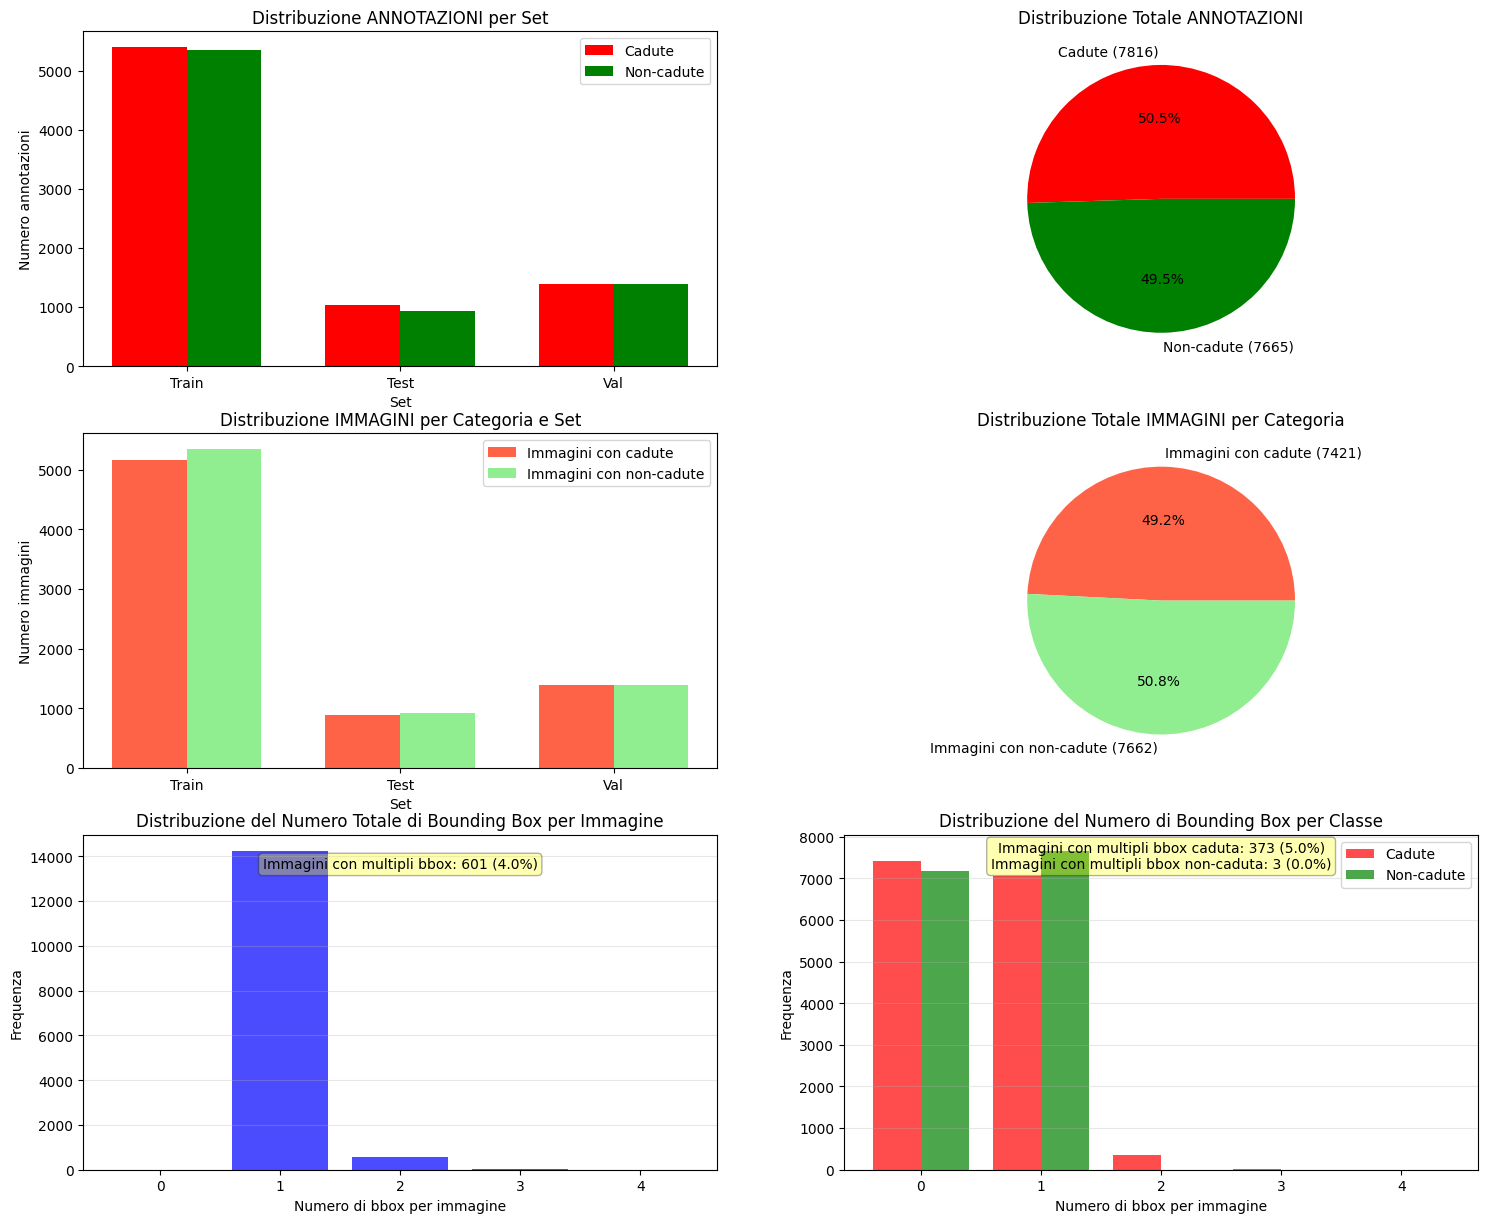

In [14]:
# Visualizzazioni
visualizza_statistiche(dati, bboxes, distribuzione_bbox)

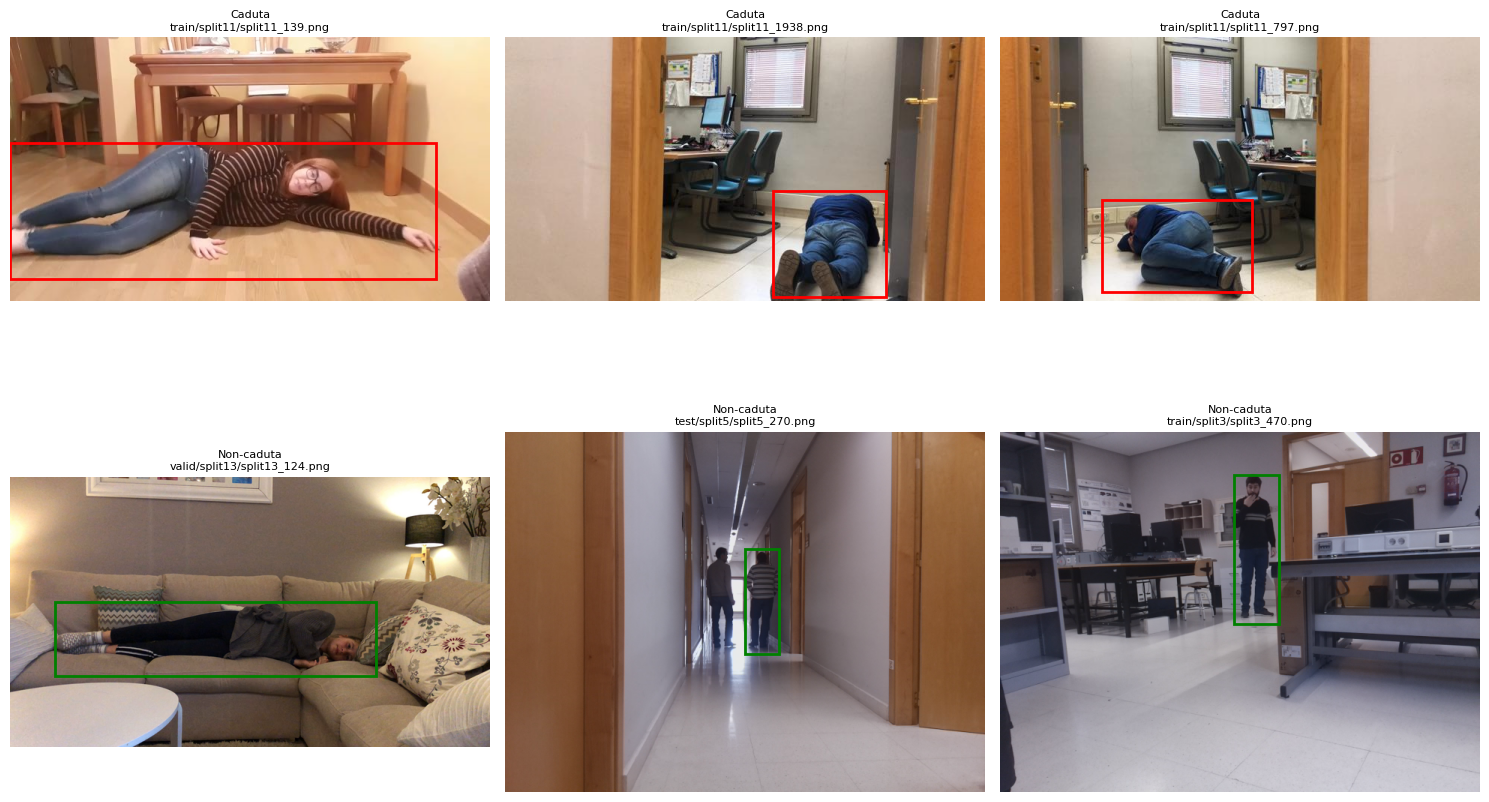

In [16]:
# Mostra esempi
mostra_esempi("Datasets/E-FPDS")

In [ ]:
import os
print(os.listdir("."))  

# 1. Preparazione del Dataset

In [ ]:
"""
Script per verificare e modificare le annotazioni del dataset
Obiettivo: 0 per not_fallen, 1 per fallen, nessuna label se nessun soggetto
"""

class DatasetAnnotationChecker:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.annotations = []
        self.annotation_stats = Counter()
        self.class_mapping = {}
        
    def scan_dataset(self):
        """Scansiona il dataset per trovare tutti i tipi di annotazioni"""
        print(f"Scansionando il dataset in: {self.dataset_path}")
        
        # Cerca file di annotazioni comuni
        annotation_files = []
        
        for root, dirs, files in os.walk(self.dataset_path):
            for file in files:
                if file.endswith(('.json', '.txt', '.csv', '.xml', '.yaml', '.yml')):
                    annotation_files.append(os.path.join(root, file))
        
        print(f"Trovati {len(annotation_files)} possibili file di annotazioni")
        
        # Analizza ogni file
        for file_path in annotation_files:
            try:
                if file_path.endswith('.json'):
                    self._parse_json_annotations(file_path)
                elif file_path.endswith('.txt'):
                    self._parse_txt_annotations(file_path)
                elif file_path.endswith('.csv'):
                    self._parse_csv_annotations(file_path)
                # Aggiungi altri formati se necessario
            except Exception as e:
                print(f"Errore nel parsing di {file_path}: {e}")
        
        self._analyze_annotations()
    
    def _parse_json_annotations(self, file_path):
        """Parsing file JSON"""
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                self._extract_labels_from_json(data, file_path)
            except json.JSONDecodeError:
                # Prova a leggere come JSONL (una riga per JSON)
                f.seek(0)
                for line_num, line in enumerate(f, 1):
                    try:
                        data = json.loads(line.strip())
                        self._extract_labels_from_json(data, f"{file_path}:line{line_num}")
                    except:
                        continue
    
    def _extract_labels_from_json(self, data, source):
        """Estrae le label da strutture JSON"""
        def extract_recursive(obj, path=""):
            if isinstance(obj, dict):
                # Cerca chiavi comuni per le label
                label_keys = ['label', 'class', 'category', 'annotation', 'gt', 'ground_truth', 'target']
                for key in label_keys:
                    if key in obj:
                        self.annotations.append({
                            'source': source,
                            'path': f"{path}.{key}" if path else key,
                            'value': obj[key],
                            'type': type(obj[key]).__name__
                        })
                
                # Ricerca ricorsiva
                for k, v in obj.items():
                    extract_recursive(v, f"{path}.{k}" if path else k)
            
            elif isinstance(obj, list):
                for i, item in enumerate(obj):
                    extract_recursive(item, f"{path}[{i}]")
        
        extract_recursive(data)
    
    def _parse_txt_annotations(self, file_path):
        """Parsing file TXT (formato YOLO o simili)"""
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if line and not line.startswith('#'):
                    # Formato YOLO: class_id x y w h
                    parts = line.split()
                    if parts:
                        try:
                            # Primo elemento è spesso la classe
                            class_val = parts[0]
                            # Prova a convertire in numero
                            try:
                                class_val = int(class_val)
                            except:
                                try:
                                    class_val = float(class_val)
                                except:
                                    pass  # Mantieni come stringa
                            
                            self.annotations.append({
                                'source': file_path,
                                'path': f"line{line_num}",
                                'value': class_val,
                                'type': type(class_val).__name__,
                                'full_line': line
                            })
                        except:
                            continue
    
    def _parse_csv_annotations(self, file_path):
        """Parsing file CSV"""
        try:
            df = pd.read_csv(file_path)
            # Cerca colonne che potrebbero contenere label
            label_columns = []
            for col in df.columns:
                col_lower = col.lower()
                if any(keyword in col_lower for keyword in ['label', 'class', 'category', 'target', 'annotation']):
                    label_columns.append(col)
            
            for col in label_columns:
                unique_values = df[col].unique()
                for val in unique_values:
                    if pd.notna(val):  # Ignora NaN
                        self.annotations.append({
                            'source': file_path,
                            'path': col,
                            'value': val,
                            'type': type(val).__name__
                        })
        except Exception as e:
            print(f"Errore nel parsing CSV {file_path}: {e}")
    
    def _analyze_annotations(self):
        """Analizza le annotazioni trovate"""
        print("\n" + "="*60)
        print("ANALISI DELLE ANNOTAZIONI TROVATE")
        print("="*60)
        
        if not self.annotations:
            print("❌ Nessuna annotazione trovata!")
            return
        
        # Conta i valori unici
        values_counter = Counter()
        sources_counter = Counter()
        types_counter = Counter()
        
        for ann in self.annotations:
            values_counter[ann['value']] += 1
            sources_counter[ann['source']] += 1
            types_counter[ann['type']] += 1
        
        print(f"📊 Totale annotazioni trovate: {len(self.annotations)}")
        print(f"📁 File con annotazioni: {len(sources_counter)}")
        
        print("\n🔢 VALORI DELLE LABEL TROVATI:")
        for value, count in values_counter.most_common():
            print(f"  {value} ({type(value).__name__}): {count} occorrenze")
        
        print("\n📂 DISTRIBUZIONE PER FILE:")
        for source, count in sources_counter.most_common():
            filename = os.path.basename(source)
            print(f"  {filename}: {count} annotazioni")
        
        # Analisi pattern
        self._detect_patterns(values_counter)
    
    def _detect_patterns(self, values_counter):
        """Rileva pattern comuni nelle annotazioni"""
        print("\n🔍 ANALISI PATTERN:")
        
        unique_values = list(values_counter.keys())
        
        # Pattern numerici
        numeric_values = []
        string_values = []
        
        for val in unique_values:
            if isinstance(val, (int, float)):
                numeric_values.append(val)
            else:
                string_values.append(val)
        
        if numeric_values:
            print(f"  📈 Valori numerici: {sorted(numeric_values)}")
            
            # Controlla se sono -1, 0, 1
            if set(numeric_values) == {-1, 0, 1}:
                print("  ✅ Pattern rilevato: valori -1, 0, 1 (possibile: -1=nessun soggetto, 0=not_fallen, 1=fallen)")
            elif set(numeric_values) == {0, 1}:
                print("  ✅ Pattern rilevato: valori binari 0, 1")
            elif set(numeric_values) == {1, 2}:
                print("  ✅ Pattern rilevato: valori 1, 2 (possibile: 1=not_fallen, 2=fallen)")
        
        if string_values:
            print(f"  📝 Valori stringa: {string_values}")
            
            # Controlla pattern comuni
            lower_strings = [s.lower() if isinstance(s, str) else s for s in string_values]
            if 'fallen' in lower_strings and 'not_fallen' in lower_strings:
                print("  ✅ Pattern rilevato: 'fallen' e 'not_fallen'")
    
    def suggest_mapping(self):
        """Suggerisce una mappatura per le label"""
        print("\n" + "="*60)
        print("SUGGERIMENTI PER LA MAPPATURA")
        print("="*60)
        
        values_counter = Counter(ann['value'] for ann in self.annotations)
        unique_values = list(values_counter.keys())
        
        print("🎯 Obiettivo: 0 per not_fallen, 1 per fallen, nessuna label per nessun soggetto")
        print("\n💡 SUGGERIMENTI:")
        
        # Suggerimenti basati sui pattern rilevati
        if -1 in unique_values and 0 in unique_values and 1 in unique_values:
            print("  📋 Mappatura suggerita per pattern (-1, 0, 1):")
            print("     -1 → Elimina (nessun soggetto)")
            print("     0 → 0 (not_fallen)")
            print("     1 → 1 (fallen)")
        
        elif any(isinstance(v, str) and 'fallen' in v.lower() for v in unique_values):
            print("  📋 Mappatura suggerita per pattern con stringhe:")
            for val in unique_values:
                if isinstance(val, str):
                    val_lower = val.lower()
                    if 'not_fallen' in val_lower or 'not fallen' in val_lower:
                        print(f"     '{val}' → 0 (not_fallen)")
                    elif 'fallen' in val_lower:
                        print(f"     '{val}' → 1 (fallen)")
        
        # Chiedi conferma per la mappatura
        self._interactive_mapping(unique_values)
    
    def _interactive_mapping(self, unique_values):
        """Mappatura interattiva"""
        print("\n🔧 CONFIGURAZIONE MAPPATURA INTERATTIVA:")
        print("Per ogni valore, specifica la nuova label (0, 1, o 'remove' per eliminare):")
        
        mapping = {}
        for val in unique_values:
            while True:
                response = input(f"  {val} → ").strip().lower()
                if response in ['0', '1']:
                    mapping[val] = int(response)
                    break
                elif response in ['remove', 'delete', 'eliminate', '']:
                    mapping[val] = 'remove'
                    break
                else:
                    print("    ⚠️  Inserisci '0', '1', o 'remove'")
        
        self.class_mapping = mapping
        print(f"\n✅ Mappatura configurata: {mapping}")
        
        # Salva la mappatura
        self._save_mapping()
    
    def _save_mapping(self):
        """Salva la mappatura in un file"""
        mapping_file = os.path.join(self.dataset_path, 'label_mapping.json')
        
        mapping_data = {
            'timestamp': pd.Timestamp.now().isoformat(),
            'original_target': "0 per not_fallen, 1 per fallen, nessuna label per nessun soggetto",
            'mapping': self.class_mapping,
            'source_analysis': {
                'total_annotations': len(self.annotations),
                'unique_values': list(set(ann['value'] for ann in self.annotations))
            }
        }
        
        with open(mapping_file, 'w', encoding='utf-8') as f:
            json.dump(mapping_data, f, indent=2, ensure_ascii=False, default=str)
        
        print(f"💾 Mappatura salvata in: {mapping_file}")
    
    def generate_conversion_script(self):
        """Genera uno script per applicare la conversione"""
        if not self.class_mapping:
            print("❌ Nessuna mappatura configurata!")
            return
        
        script_content = f'''#!/usr/bin/env python3
"""
Script generato automaticamente per convertire le annotazioni
Mappatura: {self.class_mapping}
"""

import os
import json
import shutil
from datetime import datetime

def convert_annotations(dataset_path):
    """Converte le annotazioni secondo la mappatura specificata"""
    
    mapping = {json.dumps(self.class_mapping, default=str)}
    
    # Crea backup
    backup_dir = os.path.join(dataset_path, f"backup_{{datetime.now().strftime('%Y%m%d_%H%M%S')}}")
    os.makedirs(backup_dir, exist_ok=True)
    
    print(f"🔄 Creando backup in: {{backup_dir}}")
    
    # Applica la conversione ai file trovati
    # [Qui inseriresti la logica specifica per il tuo formato di annotazioni]
    
    print("✅ Conversione completata!")

if __name__ == "__main__":
    dataset_path = input("Inserisci il path del dataset: ").strip()
    convert_annotations(dataset_path)
'''
        
        script_file = os.path.join(self.dataset_path, 'convert_annotations.py')
        with open(script_file, 'w', encoding='utf-8') as f:
            f.write(script_content)
        
        print(f"🔧 Script di conversione generato: {script_file}")

checker = DatasetAnnotationChecker('/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset')

checker.scan_dataset()

## Conversione dei label in formato YOLO

In [ ]:
def converti_annotazioni_yolo(base_path="E-FPDS", output_path="yolo_dataset"):
    """Converte le annotazioni dal formato E-FPDS al formato YOLO, supportando sia 'valid' che 'val'."""
    
    # Crea struttura cartelle
    os.makedirs(f"{output_path}/images/train", exist_ok=True)
    os.makedirs(f"{output_path}/images/val", exist_ok=True)   # Sempre 'val' nella destinazione
    os.makedirs(f"{output_path}/images/test", exist_ok=True)
    os.makedirs(f"{output_path}/labels/train", exist_ok=True)
    os.makedirs(f"{output_path}/labels/val", exist_ok=True)   # Sempre 'val' nella destinazione
    os.makedirs(f"{output_path}/labels/test", exist_ok=True)
    
    # Mappatura split - gestisce sia 'valid' che 'val' come fonte
    mappatura = {
        'train': ['split1', 'split2', 'split3', 'split10', 'split11'],
        'test': ['split4', 'split5', 'split6', 'split7', 'split8'],
    }
    
    # Verifica se esiste 'valid' o 'val' e aggiorna la mappatura
    if os.path.exists(os.path.join(base_path, "valid")):
        mappatura['valid'] = ['split12', 'split13']  # Usa 'valid' come chiave se esiste la cartella
        validation_source = "valid"
        print("Trovata cartella 'valid', verrà usata come validation set.")
    elif os.path.exists(os.path.join(base_path, "val")):
        mappatura['val'] = ['split12', 'split13']    # Usa 'val' come chiave se esiste già
        validation_source = "val"
        print("Trovata cartella 'val', verrà usata come validation set.")
    else:
        print("⚠️ Attenzione: nessuna cartella 'valid' o 'val' trovata!")
        validation_source = None
    
    # Contatori
    stats = {'train': 0, 'val': 0, 'test': 0}
    
    # Processa ogni split
    for set_name, splits in mappatura.items():
        # Determina la destinazione (sempre 'val' per il validation set)
        dest_set = "val" if set_name in ["valid", "val"] else set_name
        
        for split in splits:
            split_path = os.path.join(base_path, set_name, split)
            
            if not os.path.exists(split_path):
                print(f"Split non trovato: {split_path}")
                continue
            
            # Trova tutti i file PNG
            img_files = [f for f in os.listdir(split_path) if f.endswith('.png')]
            
            for img_file in img_files:
                img_path = os.path.join(split_path, img_file)
                txt_file = img_file.replace('.png', '.txt')
                txt_path = os.path.join(split_path, txt_file)
                
                # Copia solo se esiste il file di annotazione
                if os.path.exists(txt_path):
                    # 1. Copia immagine
                    dest_img = f"{output_path}/images/{dest_set}/{img_file}"
                    shutil.copy(img_path, dest_img)
                    
                    # 2. Leggi dimensioni immagine
                    try:
                        img = Image.open(img_path)
                        img_width, img_height = img.size
                        img.close()
                        
                        # 3. Converti e scrivi annotazioni
                        with open(txt_path, 'r') as f_in:
                            yolo_lines = []
                            
                            for line in f_in:
                                parts = line.strip().split()
                                if len(parts) >= 5:
                                    try:
                                        # Estrai classe e coordinate
                                        class_id = int(parts[0])
                                        left = int(parts[1])
                                        right = int(parts[2])
                                        top = int(parts[3])
                                        bottom = int(parts[4])
                                        
                                        # Converti classe per YOLO
                                        # 1 (caduta) -> 1, -1 (non-caduta) -> 0
                                        yolo_class = 1 if class_id == 1 else 0
                                        
                                        # Calcola coordinate normalizzate per YOLO
                                        # Formato YOLO: <class> <x_center> <y_center> <width> <height>
                                        x_center = (left + right) / 2 / img_width
                                        y_center = (top + bottom) / 2 / img_height
                                        width = (right - left) / img_width
                                        height = (bottom - top) / img_height
                                        
                                        # Aggiungi linea nel formato YOLO
                                        yolo_line = f"{yolo_class} {x_center} {y_center} {width} {height}\n"
                                        yolo_lines.append(yolo_line)
                                    except:
                                        continue
                            
                            # Scrivi file di annotazione YOLO
                            if yolo_lines:
                                with open(f"{output_path}/labels/{dest_set}/{txt_file}", 'w') as f_out:
                                    f_out.writelines(yolo_lines)
                                    stats[dest_set] += 1
                    except Exception as e:
                        print(f"Errore processing {img_path}: {e}")
    
    # Crea file data.yaml per YOLOv11
    yaml_content = f"""
# Dataset for Fallen People Detection
path: {os.path.abspath(output_path)}
train: images/train
val: images/val
test: images/test

# Classes
names:
  0: not_fallen
  1: fallen

# Info
"""
    
    with open(f"{output_path}/data.yaml", 'w') as f:
        f.write(yaml_content)
    
    print("\n✅ CONVERSIONE COMPLETATA")
    print(f"Immagini train: {stats['train']}")
    print(f"Immagini val: {stats['val']} (da: {validation_source})")
    print(f"Immagini test: {stats['test']}")
    print(f"File data.yaml creato in: {output_path}/data.yaml")
    
    return stats

# Esegui conversione
stats = converti_annotazioni_yolo("Datasets/E-FPDS", "Datasets/yolo_dataset")

# 2. Installazione di YOLOv11


In [ ]:
!pip3 install ultralytics

# 3. Training del Modello


### 3.1 Balancing 

In [ ]:
def create_balanced_dataset(source_path, dest_path, balance_ratio=0.5):
    """
    Crea un dataset perfettamente bilanciato con la percentuale specificata per ogni classe.
    
    Args:
        source_path: Path del dataset originale (formato YOLO)
        dest_path: Path dove salvare il dataset bilanciato
        balance_ratio: Rapporto desiderato (0.5 per 50/50)
    """
    print(f"🔄 Creazione dataset bilanciato ({balance_ratio*100:.0f}% cadute / {(1-balance_ratio)*100:.0f}% non cadute)")
    
    # 1. Crea struttura directory
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(dest_path, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(dest_path, 'labels', split), exist_ok=True)
    
    # 2. Analizza le etichette esistenti e classifica le immagini
    dataset_map = {'train': {}, 'val': {}, 'test': {}}
    image_classes = {'train': {'fallen': [], 'not_fallen': []}, 
                    'val': {'fallen': [], 'not_fallen': []}, 
                    'test': {'fallen': [], 'not_fallen': []}}
    
    print("Analisi dataset originale...")
    for split in ['train', 'val', 'test']:
        # Trova tutti i file di etichette
        label_dir = os.path.join(source_path, 'labels', split)
        image_dir = os.path.join(source_path, 'images', split)
        
        if not os.path.exists(label_dir) or not os.path.exists(image_dir):
            print(f"⚠️ Directory {split} non trovata, saltata")
            continue
        
        # Analizza ogni file di etichette
        for label_file in tqdm(os.listdir(label_dir), desc=f"Analisi {split}"):
            if not label_file.endswith('.txt'):
                continue
                
            image_base = label_file.replace('.txt', '')
            img_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
            img_file = None
            
            # Trova immagine corrispondente
            for ext in img_extensions:
                candidate = image_base + ext
                if os.path.exists(os.path.join(image_dir, candidate)):
                    img_file = candidate
                    break
            
            if not img_file:
                continue  # Salta se non trova l'immagine
            
            # Leggi il file di etichette per determinare la classe
            with open(os.path.join(label_dir, label_file), 'r') as f:
                lines = f.readlines()
                
                # Controlla ogni bbox nell'immagine
                has_fallen = False
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        if class_id == 0:  # classe 'fallen' in formato YOLO
                            has_fallen = True
                            break
                
                # Assegna immagine alla categoria appropriata
                category = 'fallen' if has_fallen else 'not_fallen'
                image_classes[split][category].append({
                    'img': os.path.join(image_dir, img_file),
                    'label': os.path.join(label_dir, label_file)
                })
    
    # 3. Stampa statistiche originali
    print("\n📊 STATISTICHE DATASET ORIGINALE:")
    total_fallen = sum(len(image_classes[s]['fallen']) for s in ['train', 'val', 'test'])
    total_not_fallen = sum(len(image_classes[s]['not_fallen']) for s in ['train', 'val', 'test'])
    total_images = total_fallen + total_not_fallen
    
    print(f"Totale immagini: {total_images}")
    print(f"Cadute: {total_fallen} ({total_fallen/total_images*100:.1f}%)")
    print(f"Non cadute: {total_not_fallen} ({total_not_fallen/total_images*100:.1f}%)")
    
    for split in ['train', 'val', 'test']:
        fallen = len(image_classes[split]['fallen'])
        not_fallen = len(image_classes[split]['not_fallen'])
        total = fallen + not_fallen
        if total > 0:
            print(f"\n{split.upper()}:")
            print(f"  Cadute: {fallen} ({fallen/total*100:.1f}%)")
            print(f"  Non cadute: {not_fallen} ({not_fallen/total*100:.1f}%)")
    
    # 4. Bilancia ogni split mantenendo la dimensione originale
    balanced_stats = {'train': {'fallen': 0, 'not_fallen': 0},
                     'val': {'fallen': 0, 'not_fallen': 0},
                     'test': {'fallen': 0, 'not_fallen': 0}}
    
    print("\n🔄 BILANCIAMENTO DATASET...")
    for split in ['train', 'val', 'test']:
        print(f"\nBilanciamento {split}:")
        
        # Calcola il numero totale di immagini da mantenere per questo split
        fallen = len(image_classes[split]['fallen'])
        not_fallen = len(image_classes[split]['not_fallen'])
        total_orig = fallen + not_fallen
        
        if total_orig == 0:
            print(f"  Saltato: nessuna immagine in {split}")
            continue
            
        # Determina il numero target di immagini per ogni classe
        # Strategia: manteniamo lo stesso numero totale ma ribilanciamo
        total_target = total_orig  # Mantenere la dimensione originale
        fallen_target = int(total_target * balance_ratio)
        not_fallen_target = total_target - fallen_target
        
        # Calcola quante immagini aggiungere o rimuovere per ogni classe
        # Motivazione: Usiamo la strategia più conservativa tra over/under sampling
        if fallen > fallen_target:
            # Downsampling della classe fallen
            fallen_indices = random.sample(range(fallen), fallen_target)
            fallen_samples = [image_classes[split]['fallen'][i] for i in fallen_indices]
            print(f"  Downsampling cadute: {fallen} → {fallen_target}")
        else:
            # Upsampling della classe fallen
            # Usa tutte le immagini originali
            fallen_samples = image_classes[split]['fallen'].copy()
            # Aggiungi duplicati con augmentation fino a raggiungere il target
            needed = fallen_target - fallen
            print(f"  Upsampling cadute: {fallen} → {fallen_target} (+ {needed} copie con augmentation)")
            
            # Se servono duplicati, scegli immagini casuali e applica augmentation
            if needed > 0:
                for _ in range(needed):
                    # Scegli immagine casuale da duplicare
                    original = random.choice(image_classes[split]['fallen'])
                    fallen_samples.append(original)  # Per semplicità, aggiungiamo l'originale
                    # Nella versione reale, qui applicheremmo augmentation
        
        if not_fallen > not_fallen_target:
            # Downsampling della classe not_fallen
            not_fallen_indices = random.sample(range(not_fallen), not_fallen_target)
            not_fallen_samples = [image_classes[split]['not_fallen'][i] for i in not_fallen_indices]
            print(f"  Downsampling non cadute: {not_fallen} → {not_fallen_target}")
        else:
            # Upsampling della classe not_fallen
            not_fallen_samples = image_classes[split]['not_fallen'].copy()
            needed = not_fallen_target - not_fallen
            print(f"  Upsampling non cadute: {not_fallen} → {not_fallen_target} (+ {needed} copie con augmentation)")
            
            # Se servono duplicati
            if needed > 0:
                for _ in range(needed):
                    original = random.choice(image_classes[split]['not_fallen'])
                    not_fallen_samples.append(original)  # Per semplicità
        
        # 5. Copia i file selezionati nel nuovo dataset
        print(f"  Copia files per {split}...")
        
        # Copia immagini cadute
        for idx, sample in enumerate(tqdm(fallen_samples, desc="Copia cadute")):
            img_src = sample['img']
            label_src = sample['label']
            
            img_extension = os.path.splitext(img_src)[1]
            
            # Se è un duplicato, aggiungi un suffisso
            img_filename = f"{split}_fallen_{idx}{img_extension}"
            label_filename = f"{split}_fallen_{idx}.txt"
            
            # Copia immagine
            shutil.copy2(img_src, os.path.join(dest_path, 'images', split, img_filename))
            
            # Copia e modifica etichetta
            with open(label_src, 'r') as src_f:
                with open(os.path.join(dest_path, 'labels', split, label_filename), 'w') as dst_f:
                    for line in src_f:
                        dst_f.write(line)  # Conserva l'etichetta originale
            
            balanced_stats[split]['fallen'] += 1
        
        # Copia immagini non cadute
        for idx, sample in enumerate(tqdm(not_fallen_samples, desc="Copia non cadute")):
            img_src = sample['img']
            label_src = sample['label']
            
            img_extension = os.path.splitext(img_src)[1]
            
            # Se è un duplicato, aggiungi un suffisso
            img_filename = f"{split}_not_fallen_{idx}{img_extension}"
            label_filename = f"{split}_not_fallen_{idx}.txt"
            
            # Copia immagine
            shutil.copy2(img_src, os.path.join(dest_path, 'images', split, img_filename))
            
            # Copia e modifica etichetta
            with open(label_src, 'r') as src_f:
                with open(os.path.join(dest_path, 'labels', split, label_filename), 'w') as dst_f:
                    for line in src_f:
                        dst_f.write(line)  # Conserva l'etichetta originale
            
            balanced_stats[split]['not_fallen'] += 1
    
    # 6. Crea file data.yaml per il dataset bilanciato
    yaml_content = f"""
# Dataset for Fallen People Detection (Balanced 50/50)
path: {os.path.abspath(dest_path)}
train: images/train
val: images/val
test: images/test

# Classes
names:
  0: not_fallen
  1: fallen

# Info
"""
    
    with open(os.path.join(dest_path, 'data.yaml'), 'w') as f:
        f.write(yaml_content)
    
    # 7. Stampa statistiche finali
    print("\n✅ DATASET BILANCIATO CREATO")
    print("\n📊 STATISTICHE DATASET BILANCIATO:")
    total_bal_fallen = sum(balanced_stats[s]['fallen'] for s in ['train', 'val', 'test'])
    total_bal_not_fallen = sum(balanced_stats[s]['not_fallen'] for s in ['train', 'val', 'test'])
    total_bal = total_bal_fallen + total_bal_not_fallen
    
    print(f"Totale immagini: {total_bal}")
    print(f"Cadute: {total_bal_fallen} ({total_bal_fallen/total_bal*100:.1f}%)")
    print(f"Non cadute: {total_bal_not_fallen} ({total_bal_not_fallen/total_bal*100:.1f}%)")
    
    for split in ['train', 'val', 'test']:
        fallen = balanced_stats[split]['fallen']
        not_fallen = balanced_stats[split]['not_fallen']
        total = fallen + not_fallen
        if total > 0:
            print(f"\n{split.upper()}:")
            print(f"  Cadute: {fallen} ({fallen/total*100:.1f}%)")
            print(f"  Non cadute: {not_fallen} ({not_fallen/total*100:.1f}%)")
    
    print(f"\nDataset bilanciato salvato in: {dest_path}")
    print(f"File data.yaml creato in: {os.path.join(dest_path, 'data.yaml')}")
    
    return balanced_stats

# Esempio di utilizzo
balanced_stats = create_balanced_dataset(
    source_path="Datasets/yolo_dataset", 
    dest_path="Datasets/balanced_yolo_dataset",
    balance_ratio=0.5  # 50% cadute, 50% non cadute
)

In [17]:
dati, bboxes, distribuzione_bbox = analizza_dataset(
    "Datasets/balanced_yolo_dataset", 
    formato="yolo",
    classi_yolo={1: 'caduta', 0: 'non_caduta'}
)

Analisi dataset: Datasets/balanced_yolo_dataset (formato: yolo)
Directory non trovata per set valid: Datasets/balanced_yolo_dataset/images/valid o Datasets/balanced_yolo_dataset/labels/valid

--- STATISTICHE DATASET ---
Immagini totali: 14844
Annotazioni totali: 15481
Annotazioni di cadute: 7665 (49.5%)
Annotazioni di non-cadute: 7816 (50.5%)

Immagini con cadute: 7662 (51.6%)
Immagini con non-cadute: 7421 (50.0%)
Immagini con entrambe le categorie: 7182

--- STATISTICHE PER SET ---

TRAIN:
  Immagini: 10308
  Annotazioni totali: 10735
  Annotazioni di cadute: 5343 (49.8%)
  Annotazioni di non-cadute: 5392 (50.2%)
  Immagini con cadute: 5343 (51.8%)
  Immagini con non-cadute: 5154 (50.0%)

TEST:
  Immagini: 1761
  Annotazioni totali: 1966
  Annotazioni di cadute: 929 (47.3%)
  Annotazioni di non-cadute: 1037 (52.7%)
  Immagini con cadute: 926 (52.6%)
  Immagini con non-cadute: 880 (50.0%)

VAL:
  Immagini: 2775
  Annotazioni totali: 2780
  Annotazioni di cadute: 1393 (50.1%)
  Annotazi

In [ ]:
# Visualizzazioni
visualizza_statistiche(dati, bboxes, distribuzione_bbox)

In [ ]:
def analizza_multipli_bbox_per_set(dati, distribuzione_bbox):
    """Analizza e visualizza la distribuzione dei multipli bounding box per ogni set.
    
    Args:
        dati: Dizionario con statistiche del dataset per set
        distribuzione_bbox: Dizionario con distribuzioni di bounding box per immagine
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Verifica che ci siano dati di distribuzione
    if distribuzione_bbox is None or 'total' not in distribuzione_bbox or len(distribuzione_bbox['total']) == 0:
        print("Nessun dato di distribuzione disponibile per l'analisi")
        return
    
    # Assicuriamoci che i dati siano in formato numpy array
    if not isinstance(distribuzione_bbox['total'], np.ndarray):
        distribuzione_bbox['total'] = np.array(distribuzione_bbox['total'], dtype=int)
    if not isinstance(distribuzione_bbox['fallen'], np.ndarray):
        distribuzione_bbox['fallen'] = np.array(distribuzione_bbox['fallen'], dtype=int)
    if not isinstance(distribuzione_bbox['not_fallen'], np.ndarray):
        distribuzione_bbox['not_fallen'] = np.array(distribuzione_bbox['not_fallen'], dtype=int)
    
    # Trova i set presenti nei dati
    set_presenti = sorted([s for s in dati.keys() if dati[s]['immagini'] > 0])
    
    # Gestione caso in cui 'set_info' non è presente (per compatibilità con dati analizzati in precedenza)
    if 'set_info' not in distribuzione_bbox:
        print("\nATTENZIONE: Informazioni sui set non disponibili nei dati di distribuzione.")
        print("È necessario eseguire nuovamente l'analisi utilizzando la versione aggiornata della funzione 'analizza_dataset'.")
        
        # Creiamo un'analisi aggregata invece di per-set
        print("\n--- ANALISI AGGREGATA MULTIPLI BOUNDING BOX ---")
        
        # Calcola statistiche generali
        total_bbox = distribuzione_bbox['total']
        fallen_bbox = distribuzione_bbox['fallen']
        not_fallen_bbox = distribuzione_bbox['not_fallen']
        
        total_imgs = len(total_bbox)
        multi_bbox = np.sum(total_bbox > 1)
        multi_fallen = np.sum(fallen_bbox > 1)
        multi_not_fallen = np.sum(not_fallen_bbox > 1)
        with_both = np.sum((fallen_bbox > 0) & (not_fallen_bbox > 0))
        
        pct_multi = (multi_bbox / total_imgs) * 100 if total_imgs > 0 else 0
        pct_multi_fallen = (multi_fallen / total_imgs) * 100 if total_imgs > 0 else 0
        pct_multi_not_fallen = (multi_not_fallen / total_imgs) * 100 if total_imgs > 0 else 0
        pct_both = (with_both / total_imgs) * 100 if total_imgs > 0 else 0
        
        # Visualizza statistiche aggregate
        print(f"Totale immagini: {total_imgs}")
        print(f"Immagini con multipli bbox: {multi_bbox} ({pct_multi:.1f}%)")
        print(f"Immagini con multiple cadute: {multi_fallen} ({pct_multi_fallen:.1f}%)")
        print(f"Immagini con multiple non-cadute: {multi_not_fallen} ({pct_multi_not_fallen:.1f}%)")
        print(f"Immagini con entrambe le classi: {with_both} ({pct_both:.1f}%)")
        
        # Crea grafici aggregati
        plt.figure(figsize=(15, 10))
        
        # 1. Grafico distribuzione del numero totale di bbox
        plt.subplot(2, 2, 1)
        max_bbox = int(np.max(total_bbox)) if len(total_bbox) > 0 else 0
        bins = range(0, max_bbox + 2)
        
        plt.hist(total_bbox, bins=bins, alpha=0.7, color='blue', align='left', rwidth=0.8)
        plt.xlabel('Numero di bbox per immagine')
        plt.ylabel('Frequenza')
        plt.title('Distribuzione del Numero Totale di Bounding Box')
        plt.xticks(range(0, max_bbox + 1))
        plt.grid(axis='y', alpha=0.3)
        
        plt.annotate(f'Immagini con multipli bbox: {multi_bbox} ({pct_multi:.1f}%)', 
                     xy=(0.5, 0.9), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3),
                     ha='center')
        
        # 2. Grafico distribuzione del numero di bbox per classe
        plt.subplot(2, 2, 2)
        max_fallen = int(np.max(fallen_bbox)) if len(fallen_bbox) > 0 else 0
        max_not_fallen = int(np.max(not_fallen_bbox)) if len(not_fallen_bbox) > 0 else 0
        max_class = max(max_fallen, max_not_fallen)
        bins = range(0, max_class + 2)
        
        plt.hist([fallen_bbox, not_fallen_bbox], 
                 bins=bins, alpha=0.7, 
                 label=['Cadute', 'Non-cadute'], 
                 color=['red', 'green'], 
                 align='left', rwidth=0.8)
        
        plt.xlabel('Numero di bbox per immagine')
        plt.ylabel('Frequenza')
        plt.title('Distribuzione del Numero di Bounding Box per Classe')
        plt.xticks(range(0, max_class + 1))
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        plt.annotate(f'Multiple cadute: {multi_fallen} ({pct_multi_fallen:.1f}%)\n'
                     f'Multiple non-cadute: {multi_not_fallen} ({pct_multi_not_fallen:.1f}%)\n'
                     f'Con entrambe le classi: {with_both} ({pct_both:.1f}%)', 
                     xy=(0.5, 0.85), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3),
                     ha='center')
        
        plt.tight_layout()
        plt.show()
        
        return
    
    # Se 'set_info' è presente, procedi con l'analisi per set
    # Crea una figura per la distribuzione di bbox totali per set
    plt.figure(figsize=(18, 15))
    
    # Calcola il massimo numero di bbox per definire i bins
    max_bbox = int(np.max(distribuzione_bbox['total'])) if len(distribuzione_bbox['total']) > 0 else 0
    
    # 1. ANALISI DEI BBOX TOTALI PER SET
    for i, set_nome in enumerate(set_presenti):
        if set_nome not in ['train', 'test', 'valid', 'val']:
            continue
            
        # Indici delle immagini che appartengono a questo set
        indici_set = [idx for idx, s in distribuzione_bbox['set_info'].items() if s == set_nome]
        
        if not indici_set:
            continue
            
        # Ottieni la distribuzione per questo set
        total_bbox_set = distribuzione_bbox['total'][indici_set]
        fallen_bbox_set = distribuzione_bbox['fallen'][indici_set]
        not_fallen_bbox_set = distribuzione_bbox['not_fallen'][indici_set]
        
        # Grafico per i bbox totali
        plt.subplot(3, 2, i + 1)
        bins = range(0, max_bbox + 2)
        
        plt.hist(total_bbox_set, bins=bins, alpha=0.7, color='blue', align='left', rwidth=0.8)
        
        plt.xlabel('Numero di bbox per immagine')
        plt.ylabel('Frequenza')
        plt.title(f'Distribuzione Bbox Totali - {set_nome.upper()}')
        plt.xticks(range(0, max_bbox + 1))
        plt.grid(axis='y', alpha=0.3)
        
        # Statistiche sui multipli bbox
        multi_bbox = np.sum(total_bbox_set > 1)
        pct_multi = (multi_bbox / len(total_bbox_set)) * 100 if len(total_bbox_set) > 0 else 0
        
        plt.annotate(f'Immagini con multipli bbox: {multi_bbox} ({pct_multi:.1f}%)', 
                     xy=(0.5, 0.9), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3),
                     ha='center')
    
    plt.tight_layout()
    plt.suptitle('Distribuzione del Numero di Bounding Box Totali per Set', fontsize=16, y=1.02)
    plt.show()
    
    # 2. ANALISI DEI BBOX PER CLASSE E PER SET
    plt.figure(figsize=(18, 15))
    
    max_fallen = int(np.max(distribuzione_bbox['fallen'])) if len(distribuzione_bbox['fallen']) > 0 else 0
    max_not_fallen = int(np.max(distribuzione_bbox['not_fallen'])) if len(distribuzione_bbox['not_fallen']) > 0 else 0
    max_class = max(max_fallen, max_not_fallen)
    
    for i, set_nome in enumerate(set_presenti):
        if set_nome not in ['train', 'test', 'valid', 'val']:
            continue
            
        # Indici delle immagini che appartengono a questo set
        indici_set = [idx for idx, s in distribuzione_bbox['set_info'].items() if s == set_nome]
        
        if not indici_set:
            continue
            
        # Ottieni la distribuzione per questo set
        fallen_bbox_set = distribuzione_bbox['fallen'][indici_set]
        not_fallen_bbox_set = distribuzione_bbox['not_fallen'][indici_set]
        
        # Grafico per i bbox per classe
        plt.subplot(3, 2, i + 1)
        bins = range(0, max_class + 2)
        
        plt.hist([fallen_bbox_set, not_fallen_bbox_set], 
                 bins=bins, alpha=0.7, 
                 label=['Cadute', 'Non-cadute'], 
                 color=['red', 'green'], 
                 align='left', rwidth=0.8)
        
        plt.xlabel('Numero di bbox per immagine')
        plt.ylabel('Frequenza')
        plt.title(f'Distribuzione Bbox per Classe - {set_nome.upper()}')
        plt.xticks(range(0, max_class + 1))
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # Statistiche sui multipli bbox per classe
        multi_fallen = np.sum(fallen_bbox_set > 1)
        multi_not_fallen = np.sum(not_fallen_bbox_set > 1)
        
        with_fallen = np.sum(fallen_bbox_set > 0)
        with_not_fallen = np.sum(not_fallen_bbox_set > 0)
        
        pct_multi_fallen = (multi_fallen / with_fallen) * 100 if with_fallen > 0 else 0
        pct_multi_not_fallen = (multi_not_fallen / with_not_fallen) * 100 if with_not_fallen > 0 else 0
        
        # Calcola il numero di immagini con entrambi i tipi di bbox
        with_both = np.sum((fallen_bbox_set > 0) & (not_fallen_bbox_set > 0))
        pct_both = (with_both / len(fallen_bbox_set)) * 100 if len(fallen_bbox_set) > 0 else 0
        
        plt.annotate(f'Cadute multiple: {multi_fallen} ({pct_multi_fallen:.1f}%)\n'
                     f'Non-cadute multiple: {multi_not_fallen} ({pct_multi_not_fallen:.1f}%)\n'
                     f'Con entrambe le classi: {with_both} ({pct_both:.1f}%)', 
                     xy=(0.5, 0.85), xycoords='axes fraction', 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3),
                     ha='center')
    
    plt.tight_layout()
    plt.suptitle('Distribuzione del Numero di Bounding Box per Classe e per Set', fontsize=16, y=1.02)
    plt.show()
    
    # 3. TABELLA RIASSUNTIVA
    print("\n--- ANALISI MULTIPLI BOUNDING BOX PER SET ---")
    print("┌" + "─" * 100 + "┐")
    print("│ {:<10} │ {:<15} │ {:<15} │ {:<15} │ {:<15} │ {:<15} │".format(
        "SET", "Tot Immagini", "Multi Bbox", "Multi Cadute", "Multi Non-cadute", "Con Entrambe"))
    print("├" + "─" * 100 + "┤")
    
    # Calcola le statistiche per ogni set
    for set_nome in set_presenti:
        if set_nome not in ['train', 'test', 'valid', 'val']:
            continue
            
        # Indici delle immagini che appartengono a questo set
        indici_set = [idx for idx, s in distribuzione_bbox['set_info'].items() if s == set_nome]
        
        if not indici_set:
            continue
            
        # Statistiche
        total_imgs = len(indici_set)
        total_bbox_set = distribuzione_bbox['total'][indici_set]
        fallen_bbox_set = distribuzione_bbox['fallen'][indici_set]
        not_fallen_bbox_set = distribuzione_bbox['not_fallen'][indici_set]
        
        multi_bbox = np.sum(total_bbox_set > 1)
        multi_fallen = np.sum(fallen_bbox_set > 1)
        multi_not_fallen = np.sum(not_fallen_bbox_set > 1)
        with_both = np.sum((fallen_bbox_set > 0) & (not_fallen_bbox_set > 0))
        
        pct_multi = (multi_bbox / total_imgs) * 100 if total_imgs > 0 else 0
        pct_multi_fallen = (multi_fallen / total_imgs) * 100 if total_imgs > 0 else 0
        pct_multi_not_fallen = (multi_not_fallen / total_imgs) * 100 if total_imgs > 0 else 0
        pct_both = (with_both / total_imgs) * 100 if total_imgs > 0 else 0
        
        print("│ {:<10} │ {:<15} │ {:<15} │ {:<15} │ {:<15} │ {:<15} │".format(
            set_nome.upper(), 
            f"{total_imgs}",
            f"{multi_bbox} ({pct_multi:.1f}%)",
            f"{multi_fallen} ({pct_multi_fallen:.1f}%)",
            f"{multi_not_fallen} ({pct_multi_not_fallen:.1f}%)",
            f"{with_both} ({pct_both:.1f}%)"))
    
    print("└" + "─" * 100 + "┘")

In [ ]:
analizza_multipli_bbox_per_set(dati, distribuzione_bbox)

### Con GPU


In [ ]:
"""
Addestramento ottimizzato di un modello YOLO per rilevamento cadute su GPU
"""
import os
import yaml
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta

# ========== CONFIGURAZIONE ==========
# Percorsi
DATA_PATH = 'Datasets/balanced_yolo_dataset/data.yaml'
OUTPUT_DIR = 'fallen_people_detection'
RUN_NAME = 'fpds_optimized_gpu'

# Verifica disponibilità GPU
have_gpu = torch.cuda.is_available()
if have_gpu:
    gpu_name = torch.cuda.get_device_name(0)
    gpu_count = torch.cuda.device_count()
    print(f"🔥 GPU disponibile: {gpu_name} ({gpu_count} dispositivi)")
    device = '0'  # Usa la prima GPU
else:
    print("❌ GPU non disponibile, si utilizzerà la CPU")
    device = 'cpu'

# Verifica percorsi e dataset
print(f"🔍 Verifica configurazione:")
assert os.path.exists(DATA_PATH), f"File YAML non trovato: {DATA_PATH}"

# Analisi dataset
with open(DATA_PATH, 'r') as f:
    data_config = yaml.safe_load(f)
    print(f"Dataset path: {data_config['path']}")
    
    # Verifica esistenza cartelle
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_config['path'], f"images/{split}")
        if os.path.exists(split_path):
            n_imgs = len([f for f in os.listdir(split_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  ✓ {split}: {n_imgs} immagini")
        else:
            print(f"  ✗ {split}: directory non trovata: {split_path}")

# Carica modello
model_type = 'yolov8s.pt' if have_gpu else 'yolov8n.pt'  # Small per GPU, Nano per CPU
model = YOLO(model_type)
print(f"✓ Modello caricato: {model.type}")

# ========== FUNZIONE PRINCIPALE DI ADDESTRAMENTO ==========
def train_fallen_people_detector_gpu():
    """Addestra un modello su GPU per rilevamento cadute"""
    start_time = time.time()
    print(f"⏳ Inizio addestramento su {device.upper()}...")
    
    # Configurazione ottimizzata per GPU
    results = model.train(
        data=DATA_PATH,
        epochs=150,               # Più epoche su GPU per convergenza migliore
        imgsz=640,                # Risoluzione più alta per GPU
        batch=16 if have_gpu else 4, # Batch più grande per GPU
        device=device,            # Dispositivo configurato
        workers=8 if have_gpu else os.cpu_count(),  # Workers per data loading
        
        # Pesi delle classi per bilanciamento (favorisce classe 'cadute')
        class_weights={0: 4.0, 1: 1.0},  # 0=cadute, 1=non-cadute (peso maggiore su GPU)
        
        # Loss e ottimizzazione
        optimizer='AdamW',        # Migliore convergenza per dati sbilanciati
        lr0=0.001,                # Learning rate iniziale
        lrf=0.00001,              # Learning rate finale
        weight_decay=0.0005,      # Regolarizzazione
        warmup_epochs=3,          # Warm-up
        cos_lr=True,              # Learning rate con andamento cosinusoidale
        
        # Early stopping
        patience=20,              # Più pazienza con dataset grande
        
        # Data augmentation per bilanciamento classi
        augment=True,
        mosaic=1.0,               # Massimo mosaic 
        mixup=0.4,                # Aumentato per varietà
        copy_paste=0.4,           # Copia oggetti tra immagini
        translate=0.2,            # Traslazione
        scale=0.6,                # Scala variabile
        fliplr=0.5,               # Flip orizzontale
        degrees=5.0,              # Rotazione leggera
        
        # Favorire il recall (ridurre falsi negativi)
        box=0.07,                 # Ridotto ancora di più per favorire detection (default 0.1)
        cls=0.6,                  # Aumentato per migliorare classificazione
        
        # Regolarizzazione aggiuntiva (solo GPU)
        dropout=0.0 if device == 'cpu' else 0.05,  # Leggero dropout
        
        # Logging e salvataggio
        project=OUTPUT_DIR,
        name=RUN_NAME,
        save_period=10,           # Salva ogni 10 epoche
        plots=True,               # Genera plots
        save=True,                # Salva modello finale
        verbose=True              # Log dettagliato
    )
    
    # Calcola tempo totale
    total_time = time.time() - start_time
    print(f"✅ Addestramento completato in: {timedelta(seconds=total_time)}")
    
    return results

# ========== VALIDAZIONE E ANALISI ==========
def validate_and_analyze(model):
    """Valida il modello e analizza i risultati per classe"""
    print(f"\n🔍 VALIDAZIONE MODELLO")
    print("=" * 50)
    
    # Valuta sul validation set
    print(f"Valutazione sul validation set...")
    val_results = model.val(
        data=DATA_PATH,
        split='val',
        conf=0.25,        # Soglia confidenza ridotta per cadute
        iou=0.6,          # IoU threshold
        max_det=300,      # Aumentato per scenari con molte persone
        device=device,    # Stesso dispositivo di training
        verbose=True
    )
    
    # Estrai metriche per classe
    metrics_per_class = {}
    try:
        # Precision per classe
        metrics_per_class['precision'] = val_results.box.mp_per_class.tolist() if hasattr(val_results.box, 'mp_per_class') else None
        # Recall per classe
        metrics_per_class['recall'] = val_results.box.mr_per_class.tolist() if hasattr(val_results.box, 'mr_per_class') else None
    except:
        print("⚠️ Impossibile estrarre metriche per classe")
    
    # Stampa metriche generali
    print(f"\n📊 METRICHE GENERALI:")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print(f"Precision: {val_results.box.mp:.4f}")
    print(f"Recall: {val_results.box.mr:.4f}")
    
    # Stampa metriche per classe
    if metrics_per_class.get('precision') and metrics_per_class.get('recall'):
        print(f"\n📊 METRICHE PER CLASSE:")
        class_names = ['fallen', 'not_fallen']
        for i, class_name in enumerate(class_names):
            print(f"{class_name}:")
            print(f"  Precision: {metrics_per_class['precision'][i]:.4f}")
            print(f"  Recall: {metrics_per_class['recall'][i]:.4f}")
            print(f"  F1-Score: {2*(metrics_per_class['precision'][i]*metrics_per_class['recall'][i])/(metrics_per_class['precision'][i]+metrics_per_class['recall'][i]):.4f}")
    
    # Valuta anche sul test set
    print(f"\n🔍 Valutazione sul test set...")
    test_results = model.val(
        data=DATA_PATH,
        split='test',
        conf=0.25,
        iou=0.6,
        device=device,
        verbose=True
    )
    
    # Test su alcuni esempi
    print(f"\n🖼️ TEST SU ESEMPI:")
    test_dir = os.path.join(data_config['path'], 'images/test')
    if os.path.exists(test_dir):
        # Prendi massimo 5 immagini di test casuali
        import random
        test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) 
                     if f.endswith(('.jpg', '.jpeg', '.png'))]
        if test_images:
            random.shuffle(test_images)
            test_images = test_images[:5]
            
            for img_path in test_images:
                print(f"Predizione su: {os.path.basename(img_path)}")
                # Usa soglia confidenza più bassa per classe fallen
                results = model.predict(
                    source=img_path,
                    conf=0.2,      # Soglia bassa per favorire recall
                    iou=0.6,
                    device=device,
                    save=True,
                    save_crop=True # Salva ritagli
                )
                
                # Analizza risultati
                boxes = results[0].boxes
                if len(boxes) > 0:
                    for i, box in enumerate(boxes):
                        class_id = int(box.cls.item())
                        conf = box.conf.item()
                        class_name = class_names[class_id]
                        print(f"  Detected: {class_name} (conf: {conf:.2f})")
                else:
                    print("  Nessun oggetto rilevato")
        else:
            print("  Nessuna immagine di test trovata")
    
    return val_results, test_results

# ========== ANALISI SBILANCIAMENTO E THRESHOLD OTTIMALE ==========
def analyze_threshold_impact(model):
    """Analizza l'impatto di diverse soglie di confidenza su precision e recall"""
    print(f"\n📊 ANALISI THRESHOLD OTTIMALE")
    print("=" * 50)
    
    # Soglie da testare
    thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
    results = []
    
    # Test su validation set
    for conf in thresholds:
        print(f"Valutazione con threshold = {conf}")
        val_result = model.val(data=DATA_PATH, conf=conf, iou=0.6, verbose=False)
        
        # Salva risultati
        results.append({
            'threshold': conf,
            'precision': val_result.box.mp,
            'recall': val_result.box.mr,
            'map50': val_result.box.map50,
            'f1': 2 * (val_result.box.mp * val_result.box.mr) / (val_result.box.mp + val_result.box.mr)
        })
    
    # Crea grafico
    thresholds = [r['threshold'] for r in results]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    f1_scores = [r['f1'] for r in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, 'b-', marker='o', label='Precision')
    plt.plot(thresholds, recalls, 'r-', marker='o', label='Recall')
    plt.plot(thresholds, f1_scores, 'g-', marker='o', label='F1 Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Confidence Threshold')
    plt.ylabel('Metric Value')
    plt.title('Impact of Confidence Threshold on Metrics')
    plt.legend()
    plt.savefig(os.path.join(OUTPUT_DIR, RUN_NAME, 'threshold_analysis.png'))
    plt.close()
    
    # Trova threshold ottimale per F1
    best_f1_idx = f1_scores.index(max(f1_scores))
    best_f1_threshold = thresholds[best_f1_idx]
    
    # Trova threshold per recall elevato
    high_recall_idx = next((i for i, r in enumerate(recalls) if r > 0.9), 0)
    high_recall_threshold = thresholds[high_recall_idx] if high_recall_idx < len(thresholds) else thresholds[0]
    
    print(f"\n🎯 THRESHOLD OTTIMALI:")
    print(f"Miglior F1 Score: threshold = {best_f1_threshold} (F1 = {max(f1_scores):.4f})")
    print(f"Alta Recall (safety): threshold = {high_recall_threshold} (Recall = {recalls[high_recall_idx]:.4f})")
    
    # Salva risultati in CSV
    import csv
    with open(os.path.join(OUTPUT_DIR, RUN_NAME, 'threshold_analysis.csv'), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Threshold', 'Precision', 'Recall', 'mAP50', 'F1'])
        for r in results:
            writer.writerow([r['threshold'], r['precision'], r['recall'], r['map50'], r['f1']])
    
    return best_f1_threshold, high_recall_threshold

# ========== ESPORTAZIONE E SALVATAGGIO ==========
def export_model(model):
    """Esporta il modello in formati diversi"""
    print(f"\n💾 ESPORTAZIONE MODELLO")
    print("=" * 50)
    
    # Esporta in ONNX (per deployment)
    print("Esportazione in ONNX...")
    onnx_path = model.export(format='onnx')
    print(f"✓ Modello ONNX salvato: {onnx_path}")
    
    # Esporta in altri formati utili
    if have_gpu:
        # TensorRT (solo GPU NVIDIA)
        try:
            print("Esportazione in TensorRT...")
            tensorrt_path = model.export(format='engine')
            print(f"✓ Modello TensorRT salvato: {tensorrt_path}")
        except Exception as e:
            print(f"✗ Errore esportazione TensorRT: {e}")
    
    # Esporta in Torchscript (per deployment universale)
    print("Esportazione in TorchScript...")
    try:
        torchscript_path = model.export(format='torchscript')
        print(f"✓ Modello TorchScript salvato: {torchscript_path}")
    except Exception as e:
        print(f"✗ Errore esportazione TorchScript: {e}")
    
    print(f"\n✅ MODELLO PRONTO PER L'USO")
    print(f"Percorso modelli: {os.path.join(OUTPUT_DIR, RUN_NAME)}")

# ========== ESECUZIONE PRINCIPALE ==========
if __name__ == "__main__":
    # 1. Addestramento
    results = train_fallen_people_detector_gpu()
    
    # 2. Validazione e analisi
    val_results, test_results = validate_and_analyze(model)
    
    # 3. Analisi threshold ottimale
    best_f1_threshold, high_recall_threshold = analyze_threshold_impact(model)
    
    # 4. Esportazione modello
    export_model(model)
    
    print("\n🎯 ADDESTRAMENTO SU {} COMPLETATO CON SUCCESSO".format("GPU" if have_gpu else "CPU"))
    print(f"Performance migliore (F1): conf={best_f1_threshold}")
    print(f"Performance safety-critical (Recall): conf={high_recall_threshold}")

### Con CPU

In [ ]:
# Percorsi
DATA_PATH = 'Datasets/balanced_yolo_dataset/data.yaml'

# Carica modello
print("Caricamento modello YOLOv11...")
model = YOLO('yolo11n.pt')

# Addestramento minimo che sicuramente funziona
def train_minimal():
    print("⏳ Inizio addestramento YOLOv11 (configurazione minima)...")
    
    # Usa SOLO i parametri core che sicuramente funzionano
    results = model.train(
        data=DATA_PATH,
        epochs=50,          # Numero epoche
        imgsz=416,          # Dimensioni ridotte
        batch=4,            # Batch piccolo
        device='cpu',       # Usa CPU
        optimizer='AdamW',  # Ottimizzatore standard
        patience=15,        # Early stopping
        project='fallen_people_detection',
        name='fpds_minimal',
        verbose=True        # Log dettagliato
    )
    
    print("✅ Addestramento completato!")
    return results

# Esegui
results = train_minimal()

# Valida
model.val(data=DATA_PATH)

# Test
test_dir = os.path.join('Datasets/yolo_dataset/images/test')
if os.path.exists(test_dir):
    test_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]
    if test_files:
        model.predict(os.path.join(test_dir, test_files[0]), save=True)

# 4. Validazione del Modello

In [7]:
from ultralytics import YOLO

model=YOLO('v8n_dataset_pierga.pt')

# Validazione sul set di validazione
val_results = model.val(data='data_pierga_v8n.yaml')

# Stampa metriche
print(f"mAP50: {val_results.box.map50}")
print(f"mAP50-95: {val_results.box.map}")
print(f"Precision: {val_results.box.mp}")
print(f"Recall: {val_results.box.mr}")

Ultralytics 8.3.147  Python-3.13.0 torch-2.7.0+cpu CPU (Intel Core(TM) i3-8100 3.60GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 9.91MB/s]


FileNotFoundError: [34m[1mval: [0mError loading data from C:\Users\Utente\Desktop\EyesOnFalls\Eyes_on_Falls_YOLO\Pierga_eof_YOLO\dataset\images\val
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

# 5. Test su Immagini di Esempio


In [19]:
# Testa il modello su immagini specifiche
results = model.predict(source='Datasets/balanced_yolo_dataset/images/test', save=True, conf=0.25)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1761 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test/Subject 1_01_10.jpg: 256x416 1 not_fallen, 24.3ms
image 2/1761 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test/Subject 1_01_13.jpg: 256x416 1 not_fallen, 47.2ms
image 3/1761 /Users/andreavisi/Desktop/PYTHON/Sistemi oper

# 6. Esportazione del Modello


In [20]:
# Esporta il modello in vari formati
model.export(format='onnx')  # Esporta in ONNX
# Altri formati: 'torchscript', 'tflite', 'coreml', ecc.

Ultralytics 8.3.146 🚀 Python-3.13.3 torch-2.7.0 CPU (Apple M1 Pro)

PyTorch: starting from '/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/fallen_people_detection/fpds_minimal/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 6, 3549) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.53', 'onnxruntime'] not found, attempting AutoUpdate...


DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  ERROR: Command errored out with exit status 1:
   command: /Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /var/folders/zt/9ggmn83106zfjymwl_r2kkdh0000gn/T/tmpetP6qA
       cwd: /private/var/folders/zt/9ggmn83106zfjymwl_r2kkdh0000gn/T/pip-install-E2pdsU/onnx
  Complete output (19 lines):
  Traceback (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pip/_vendor/pep517/_in_process.py", line 207, in 

WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.53" "onnxruntime" ' returned non-zero exit status 1.


You should consider upgrading via the 'pip install --upgrade pip' command.
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  ERROR: Command errored out with exit status 1:
   command: /Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /var/folders/zt/9ggmn83106zfjymwl_r2kkdh0000gn/T/tmp4zO3Lj
       cwd: /private/var/folders/zt/9ggmn83106zfjymwl_r2kkdh0000gn/T/pip-install-icSS40/onnx
  Complete output (19 lines):
  Traceback (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/2.7/li

WARNING ⚠️ Retry 2/2 failed: Command 'pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.53" "onnxruntime" ' returned non-zero exit status 1.
WARNING ⚠️ requirements: ❌ Command 'pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.53" "onnxruntime" ' returned non-zero exit status 1.
ERROR ❌ ONNX: export failure 21.0s: No module named 'onnx'


You should consider upgrading via the 'pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'onnx'

# 7. Valutazione su Casi Specifici


In [22]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def test_on_image(model, image_path):
    """Test del modello su un'immagine specifica con visualizzazione."""
    # Carica immagine
    img = Image.open(image_path)
    
    # Predizione
    results = model.predict(image_path, conf=0.25)
    
    # Visualizza risultati
    plt.figure(figsize=(10, 8))
    plt.imshow(np.array(img))
    
    # Estrai risultati
    boxes = results[0].boxes.xyxy.cpu().numpy()  # x1, y1, x2, y2
    confs = results[0].boxes.conf.cpu().numpy()
    cls = results[0].boxes.cls.cpu().numpy()
    
    # Disegna bounding box
    for box, conf, cl in zip(boxes, confs, cls):
        x1, y1, x2, y2 = box
        color = 'red' if cl == 0 else 'green'
        label = f"{'Caduta' if cl == 0 else 'Non-caduta'}: {conf:.2f}"
        
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                               linewidth=2, edgecolor=color, facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1-5, label, color=color, fontsize=10,
                backgroundcolor='white')
    
    plt.title(f"Predizione YOLOv11 su {image_path.split('/')[-1]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test su alcune immagini di esempio
test_paths = [
    'Datasets/balanced_yolo_dataset/images/test/split4_001.png',
    'yolo_dataset/images/test/split4_002.png',
    'yolo_dataset/images/test/split4_003.png'
]

for path in test_paths:
    test_on_image(model, path)

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/balanced_yolo_dataset/images/test/split4_001.png'

# 8. Analisi delle Prestazioni



image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test/test_fallen_294.png: 320x416 1 not_fallen, 48.9ms
Speed: 1.9ms preprocess, 48.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test/test_fallen_294.png: 320x416 1 not_fallen, 28.0ms
Speed: 0.9ms preprocess, 28.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 416)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test/test_fallen_280.png: 320x416 (no detections), 25.1ms
Speed: 0.7ms preprocess, 25.1ms inference, 0.2ms postprocess per image at shape (1, 3, 320, 416)

image 1/1 /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/ba

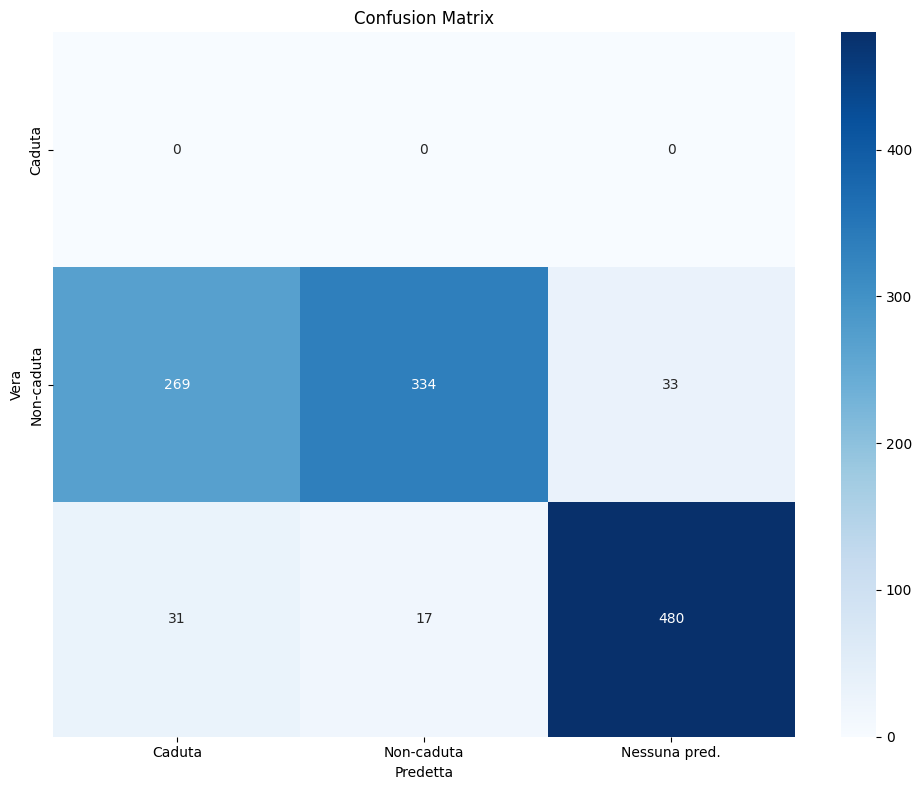


RAPPORTO CLASSIFICAZIONE:


ValueError: Found input variables with inconsistent numbers of samples: [1164, 864]

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def performance_analysis(model, test_folder='Datasets/balanced_yolo_dataset/images/test'):
    """Analisi delle prestazioni del modello."""
    import os
    
    y_true = []  # Classi vere
    y_pred = []  # Classi predette
    
    # Processa tutte le immagini di test
    for img_file in os.listdir(test_folder):
        if not img_file.endswith('.png'):
            continue
        
        img_path = os.path.join(test_folder, img_file)
        txt_path = img_path.replace('.png', '.txt').replace('/images/', '/labels/')
        
        # Leggi vera classe
        try:
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    true_class = int(parts[0])
                    y_true.append(true_class)
                    
                    # Predici
                    results = model.predict(img_path, conf=0.25)
                    
                    if len(results[0].boxes) > 0:
                        # Prendi la predizione con confidenza più alta
                        pred_class = int(results[0].boxes.cls[0].item())
                        y_pred.append(pred_class)
                    else:
                        # Nessuna predizione
                        y_pred.append(-1)  # -1 per indicare "nessuna predizione"
        except:
            continue
    
    # Crea confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualizza
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Caduta', 'Non-caduta', 'Nessuna pred.'] if -1 in y_pred else ['Caduta', 'Non-caduta'],
                yticklabels=['Caduta', 'Non-caduta'])
    plt.xlabel('Predetta')
    plt.ylabel('Vera')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Report dettagliato
    print("\nRAPPORTO CLASSIFICAZIONE:")
    print(classification_report(y_true, [p for p in y_pred if p != -1], 
                              target_names=['Caduta', 'Non-caduta']))
    
    return y_true, y_pred

# Esegui analisi
y_true, y_pred = performance_analysis(model)

# 9. Fine-Tuning per Sicurezza Critica


In [ ]:
# Addestra con focus sul recall (più importante non perdere le cadute)
results = model.train(
    data='yolo_dataset/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    # Parametri specifici per bilanciare verso recall
    hyp={
        'box': 0.1,           # Peso per box loss
        'cls': 0.7,           # Peso per class loss (più alto per enfatizzare classificazione corretta)
        'cls_pw': 1.0,        # Peso per classe positiva
        'obj': 1.0,           # Peso per objectness loss
        'obj_pw': 1.0,        # Peso per objectness positivo
        'fl_gamma': 0.0,      # Focal loss gamma
    },
    # Priorità alla classe "caduta"
    class_weights={0: 1.0, 1: 2.0},  # Raddoppia il peso per la classe caduta
)

# 10. Implementazione in Tempo Reale


In [7]:
from ultralytics import YOLO
import cv2

def monitor_video_stream(model, source=0):
    """Monitora uno stream video per rilevare cadute."""
    import cv2
    
    # Apri stream video
    cap = cv2.VideoCapture(source)
    
    while cap.isOpened():
        # Leggi frame
        success, frame = cap.read()
        if not success:
            break
        
        # Converti colori per YOLOv11
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Predici
        results = model.predict(frame_rgb, conf=0.7)
        
        # Processa risultati
        annotated_frame = results[0].plot()
        
        # Converti colori per visualizzazione
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        
        # Mostra
        cv2.imshow("YOLOv11 Fallen Person Detection", annotated_frame)
        
        # Premi 'q' per uscire
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Rilascia risorse
    cap.release()
    cv2.destroyAllWindows()

model_path = "/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/fallen_people_detection/fpds_minimal/weights/best.pt"
model = YOLO(model_path)
#model = YOLO('yolo11n.pt')

# Avvia monitoraggio (webcam)
monitor_video_stream(model, 0)


0: 256x416 (no detections), 26.9ms
Speed: 1.2ms preprocess, 26.9ms inference, 0.3ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 not_fallen, 22.4ms
Speed: 0.9ms preprocess, 22.4ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 (no detections), 23.5ms
Speed: 0.9ms preprocess, 23.5ms inference, 0.2ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 (no detections), 21.0ms
Speed: 0.9ms preprocess, 21.0ms inference, 0.2ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 (no detections), 21.0ms
Speed: 0.9ms preprocess, 21.0ms inference, 0.2ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 (no detections), 21.2ms
Speed: 1.1ms preprocess, 21.2ms inference, 0.2ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 not_fallen, 21.7ms
Speed: 0.8ms preprocess, 21.7ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 416)

0: 256x416 1 not_fallen, 22.6ms
Speed: 1.4ms preprocess, 22.6ms inference,

In [17]:
import cv2
import subprocess
import platform

def check_system_requirements():
    """Verifica i requisiti di sistema"""
    print("=== Verifica Sistema ===")
    
    # Verifica versione macOS
    mac_version = platform.mac_ver()[0]
    print(f"Versione macOS: {mac_version}")
    
    # Lista camere disponibili
    try:
        result = subprocess.run(['system_profiler', 'SPCameraDataType'], 
                              capture_output=True, text=True)
        print("\n=== Camere Rilevate ===")
        print(result.stdout)
    except:
        print("Impossibile listare le camere")

def test_all_cameras():
    """Testa tutti gli indici camera possibili"""
    print("\n=== Test Camere ===")
    
    available_cameras = []
    
    # Prova anche indici negativi (a volte macOS li usa)
    for i in range(-5, 10):
        cap = cv2.VideoCapture(i)
        if cap.isOpened():
            width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
            height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
            
            # Leggi un frame per verificare che funzioni davvero
            ret, frame = cap.read()
            if ret:
                print(f"\n✓ Camera {i} funzionante:")
                print(f"  Risoluzione: {int(width)}x{int(height)}")
                
                # Mostra preview per identificare quale è l'iPhone
                cv2.putText(frame, f"Camera Index: {i}", (10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.putText(frame, "Premi 'q' per prossima camera", (10, 60), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
                cv2.imshow(f"Test Camera {i}", frame)
                
                key = cv2.waitKey(0) & 0xFF
                cv2.destroyAllWindows()
                
                if key == ord('y'):
                    print(f"  -> Selezionata come iPhone!")
                    available_cameras.append((i, True))
                else:
                    available_cameras.append((i, False))
            
            cap.release()
    
    return available_cameras

def use_continuity_camera(model, camera_index):
    """Usa specificamente Continuity Camera"""
    cap = cv2.VideoCapture(camera_index)
    
    # Imposta proprietà per Continuity Camera
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)
    cap.set(cv2.CAP_PROP_FPS, 30)
    
    if not cap.isOpened():
        print(f"Impossibile aprire camera all'indice {camera_index}")
        return
    
    print(f"Camera {camera_index} aperta con successo!")
    print("Premi 'q' per uscire")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Frame non ricevuto")
            break
        
        # Fall detection
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = model.predict(frame_rgb, conf=0.4)
        annotated_frame = results[0].plot()
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        
        # Aggiungi info
        cv2.putText(annotated_frame, "iPhone via Continuity Camera", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow("Fall Detection - iPhone", annotated_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Esegui diagnostica
check_system_requirements()
cameras = test_all_cameras()

# Carica modello
from ultralytics import YOLO
model_path = "/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/fallen_people_detection/fpds_minimal/weights/best.pt"
model = YOLO(model_path)

# Usa la camera selezionata
if cameras:
    iphone_cameras = [c[0] for c in cameras if c[1]]
    if iphone_cameras:
        use_continuity_camera(model, iphone_cameras[0])
    else:
        print("\nNessuna camera identificata come iPhone.")
        print("Prova manualmente con questi indici:", [c[0] for c in cameras])

=== Verifica Sistema ===
Versione macOS: 15.5

=== Camere Rilevate ===
Camera:

    Fotocamera HD FaceTime:

      Model ID: Fotocamera HD FaceTime
      Unique ID: 47B4B64B-7067-4B9C-AD2B-AE273A71F4B5

    Fotocamera di iPhone 13 di Andrea:

      Model ID: iPhone14,5
      Unique ID: CCAE0F3C-6023-43B8-9448-4E6000000001



=== Test Camere ===

✓ Camera 0 funzionante:
  Risoluzione: 1920x1080


OpenCV: out device of bound (0-0): -5
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-0): -4
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-0): -3
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-0): -2
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-0): -1
OpenCV: camera failed to properly initialize!
2025-06-01 16:52:21.127 Python[31184:31802452] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.



✓ Camera 1 funzionante:
  Risoluzione: 1920x1080

Nessuna camera identificata come iPhone.
Prova manualmente con questi indici: [0, 1]


OpenCV: out device of bound (0-1): 2
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 3
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 4
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 5
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 6
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 7
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 8
OpenCV: camera failed to properly initialize!
OpenCV: out device of bound (0-1): 9
OpenCV: camera failed to properly initialize!


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Script per analizzare la distribuzione dei dati in un dataset YOLO.
Controlla la distribuzione delle classi nelle cartelle train, val e test.
"""

import os
import yaml
import argparse
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path
import seaborn as sns

def parse_args():
    parser = argparse.ArgumentParser(description='Analizza la distribuzione dei dati in un dataset YOLO')
    parser.add_argument('--yaml', type=str, required=True, help='Percorso al file YAML del dataset')
    parser.add_argument('--output', type=str, default='dataset_analysis', help='Nome del file di output per i grafici')
    return parser.parse_args()

def count_objects_in_label_file(label_file, num_classes):
    """Conta gli oggetti per classe in un file di etichette YOLO"""
    counts = [0] * num_classes
    
    if not os.path.exists(label_file):
        return counts
        
    try:
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # Formato YOLO: class_id x y width height
                    class_id = int(parts[0])
                    if 0 <= class_id < num_classes:
                        counts[class_id] += 1
    except Exception as e:
        print(f"Errore nel leggere {label_file}: {e}")
        
    return counts

def analyze_dataset(data_yaml):
    """Analizza un dataset YOLO basato sul file YAML"""
    print(f"🔍 Analisi del dataset: {data_yaml}")
    
    # Carica configurazione YAML
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Ottieni percorso base del dataset
    try:
        dataset_path = data_config['path']
        if not os.path.isabs(dataset_path):
            # Se è un percorso relativo, calcola basandosi sulla posizione del file YAML
            yaml_dir = os.path.dirname(os.path.abspath(data_yaml))
            dataset_path = os.path.join(yaml_dir, dataset_path)
    except KeyError:
        # Se 'path' non è definito, presumi che la directory del YAML sia la root del dataset
        dataset_path = os.path.dirname(os.path.abspath(data_yaml))
    
    print(f"📂 Percorso dataset: {dataset_path}")
    
    # Ottieni nomi delle classi
    classes = {}
    if 'names' in data_config:
        if isinstance(data_config['names'], dict):
            classes = data_config['names']
        elif isinstance(data_config['names'], list):
            classes = {i: name for i, name in enumerate(data_config['names'])}
        num_classes = len(classes)
    else:
        # Se non sono specificati nomi, presumi che vengano determinati dai file
        print("⚠️ Nomi delle classi non specificati nel file YAML")
        # Prova a trovare il numero massimo di classi analizzando alcuni file di etichette
        num_classes = 0  # Verrà aggiornato se vengono trovate classi nei file
        
    print(f"📊 Nomi classi: {classes}")
    
    results = {}
    splits = ['train', 'val', 'test']
    
    for split in splits:
        # Percorsi immagini e etichette
        images_dir = os.path.join(dataset_path, f"images/{split}")
        labels_dir = os.path.join(dataset_path, f"labels/{split}")
        
        if not os.path.exists(images_dir):
            print(f"⚠️ Directory immagini non trovata: {images_dir}")
            continue
            
        if not os.path.exists(labels_dir):
            print(f"⚠️ Directory etichette non trovata: {labels_dir}")
            continue
        
        # Conta le immagini
        image_files = [f for f in os.listdir(images_dir) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        num_images = len(image_files)
        
        # Inizializza contatori per le classi
        class_counts = [0] * num_classes
        images_with_class = [0] * num_classes
        total_objects = 0
        
        # Conta oggetti per classe
        for img_file in image_files:
            # Converti l'estensione del file immagine in .txt per il file etichetta
            base_name = os.path.splitext(img_file)[0]
            label_file = os.path.join(labels_dir, f"{base_name}.txt")
            
            # Conta oggetti nel file di etichetta
            obj_counts = count_objects_in_label_file(label_file, num_classes)
            
            # Aggiorna contatori
            for class_id, count in enumerate(obj_counts):
                class_counts[class_id] += count
                if count > 0:
                    images_with_class[class_id] += 1
                total_objects += count
        
        # Se non era specificato il numero di classi, determinalo ora
        if num_classes == 0 and max(class_counts, default=0) > 0:
            num_classes = max(class_counts) + 1
            classes = {i: f"Classe {i}" for i in range(num_classes)}
            
        # Salva risultati
        results[split] = {
            'num_images': num_images,
            'class_counts': class_counts,
            'images_with_class': images_with_class,
            'total_objects': total_objects,
            'objects_per_image': total_objects / num_images if num_images > 0 else 0
        }
        
        # Stampa risultati per questo split
        print(f"\n📊 Statistiche {split}:")
        print(f"  📷 Immagini totali: {num_images}")
        print(f"  🏷️ Oggetti totali: {total_objects}")
        print(f"  📊 Media oggetti per immagine: {results[split]['objects_per_image']:.2f}")
        print(f"  📈 Distribuzione classi:")
        
        for class_id, count in enumerate(class_counts):
            if class_id < len(classes):
                class_name = classes[class_id]
                percent = (count / total_objects * 100) if total_objects > 0 else 0
                img_percent = (images_with_class[class_id] / num_images * 100) if num_images > 0 else 0
                print(f"    - {class_name}: {count} oggetti ({percent:.1f}%) in {images_with_class[class_id]} immagini ({img_percent:.1f}%)")
    
    return results, classes, splits

def plot_distribution(results, classes, splits, output_name):
    """Crea grafici per visualizzare la distribuzione del dataset"""
    if not results:
        print("❌ Nessun dato da visualizzare")
        return
    
    # Imposta stile Seaborn
    sns.set(style="whitegrid")
    
    # Impostazioni figure
    plt.figure(figsize=(15, 10))
    
    # 1. Grafico a barre distribuzione classi per split
    plt.subplot(2, 1, 1)
    bar_width = 0.8 / len(splits)
    
    for i, split in enumerate(splits):
        if split not in results:
            continue
            
        data = results[split]
        class_counts = data['class_counts']
        
        x = np.arange(len(classes))
        offset = bar_width * (i - len(splits)/2 + 0.5)
        plt.bar(x + offset, class_counts, width=bar_width, label=split.capitalize())
    
    plt.xlabel('Classi', fontsize=12)
    plt.ylabel('Numero di oggetti', fontsize=12)
    plt.title('Distribuzione degli oggetti per classe', fontsize=14)
    plt.xticks(range(len(classes)), [classes[i] for i in range(len(classes))], rotation=45)
    plt.legend()
    plt.tight_layout()
    
    # 2. Grafico a torta distribuzione generale
    plt.subplot(2, 2, 3)
    total_counts = [0] * len(classes)
    
    for split in splits:
        if split not in results:
            continue
        data = results[split]
        for i, count in enumerate(data['class_counts']):
            if i < len(total_counts):
                total_counts[i] += count
    
    # Crea un grafico a torta solo se ci sono dati
    if sum(total_counts) > 0:
        plt.pie(total_counts, labels=[classes[i] for i in range(len(classes))], 
                autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Distribuzione complessiva delle classi', fontsize=14)
    
    # 3. Grafico a barre immagini e oggetti per split
    plt.subplot(2, 2, 4)
    splits_present = [s for s in splits if s in results]
    num_images = [results[s]['num_images'] for s in splits_present]
    total_objects = [results[s]['total_objects'] for s in splits_present]
    
    x = np.arange(len(splits_present))
    width = 0.35
    
    plt.bar(x - width/2, num_images, width, label='Immagini')
    plt.bar(x + width/2, total_objects, width, label='Oggetti')
    
    plt.xlabel('Split', fontsize=12)
    plt.ylabel('Conteggio', fontsize=12)
    plt.title('Immagini e oggetti per split', fontsize=14)
    plt.xticks(x, [s.capitalize() for s in splits_present])
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=300, bbox_inches='tight')
    print(f"\n✅ Grafico salvato come: {output_name}.png")
    
    # Mostra il grafico se possibile
    try:
        plt.show()
    except:
        pass

def main():
    args = parse_args()
    
    # Verifica che il file YAML esista
    if not os.path.exists(args.yaml):
        print(f"❌ File YAML non trovato: {args.yaml}")
        return
    
    # Analizza il dataset
    results, classes, splits = analyze_dataset(args.yaml)
    
    # Crea grafici
    plot_distribution(results, classes, splits, args.output)
    
    # Stampa riepilogo bilanciamento
    print("\n📊 RIEPILOGO BILANCIAMENTO DATASET:")
    all_class_counts = [0] * len(classes)
    
    for split in splits:
        if split in results:
            for i, count in enumerate(results[split]['class_counts']):
                if i < len(all_class_counts):
                    all_class_counts[i] += count
    
    total_objs = sum(all_class_counts)
    if total_objs > 0:
        max_count = max(all_class_counts)
        min_count = min(all_class_counts) if min(all_class_counts) > 0 else max_count
        imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
        
        class_with_max = [classes[i] for i, count in enumerate(all_class_counts) if count == max_count]
        class_with_min = [classes[i] for i, count in enumerate(all_class_counts) if count == min_count and count > 0]
        
        print(f"Classe più frequente: {', '.join(class_with_max)} ({max_count} oggetti)")
        print(f"Classe meno frequente: {', '.join(class_with_min)} ({min_count} oggetti)")
        print(f"Rapporto di sbilanciamento: {imbalance_ratio:.2f}:1")
        
        # Suggerimenti bilanciamento
        if imbalance_ratio > 10:
            print("\n⚠️ ATTENZIONE: Dataset fortemente sbilanciato!")
            print("Suggerimenti:")
            print("1. Considera tecniche di bilanciamento come oversampling o class weights")
            print("2. Per YOLO, puoi usare hyp.yaml con pesi delle classi per il training")
            print("3. Aggiungi più immagini per le classi minoritarie")
        elif imbalance_ratio > 3:
            print("\n⚠️ Dataset moderatamente sbilanciato")
            print("Suggerimenti:")
            print("1. Considera tecniche di bilanciamento come class weights")
            print("2. Monitora attentamente precision e recall durante il training")
        else:
            print("\n✅ Dataset relativamente bilanciato")

if __name__ == "__main__":
    main()